# Appendix A: a method for imputing values for censored data

## Overview

Appendix A focuses on imputing values for the records in the housing dataset with a censored housing_median_age.  Approximately 6% of the data (1,268 records) for this variable is capped at age 52.  

Appendix B focuses on imputing values for the records with a capped median_house_value.

Values are imputed using a Gibbs sampler.  It involves running, in this case, four random walks simultaneously.  In each, the first step is to randomly assign values from the expected imputation range to the records with censored values.  The expected imputation range for the capped housing median age values is from 52 to around 78 years.  The new set of housing median age values is then regressed on the predictors from a model previously constructed with the original housing_median_age values.  (I.e., the model the Gibbs sampler makes use of is one which is constructed with the capped values in place.)  New predictions are obtained using coefficients randomly sampled from the uncertainty distributions of the model's parameters.  With the new predictions, another model is obtained.  We repeat this process many times, essentially until we see the separate random walks converge in their estimates of the parameters.  The Gibbs sampler output includes predictions for the imputed values that we need.  These predictions are normally distributed, and the spread of the distribution depends on the R-squared of the model we employ and the range in which we expected the imputed values to lie.  The smaller we make this range, the smaller the spread of our imputed values.  The greater the R-squared of the model we rely on, the smaller the spread of the imputed values.  While smaller spreads are preferable, we do not want to choose a range for the imputed values that is likely to capture only 80% of the size of the actual range.  At the same time, we do not want to choose a range that is too great.  E.g., for housing_median_age we expect that there are districts with an age of 65, but it is not so clear that we will find many with an age > 78.  If we expect that only around 1% of the districts have an age > 78, then we will end up with a much better set of predictions, on average, keeping the upper limit of the imputation range at 78 or slightly below.

Because the models in Appendix A and Appendix B assume that the response variable is normally distributed, the Gibbs samplers relying on these models will always generate predictions which are normally distributed around a mean.  The distribution of the entire set of imputed values, in turn, has the shape of a (possibly constrained) normally distributed variable.  But this shape for the imputed values is not what we expect to see.  In Section 1 below, the analysis aims to provide a clearer picture of what this shape might be.  Section 1 shows how we can get a fairly accurate prediction for the mean of the actual, unobserved values of the censored records.  The main result of Section 1, then, is a hypothesized distribution for the imputed values.  Section 3 makes use of this result to adjust the output from the Gibbs sampler that is run in Section 2.


In Appendix C, I look at the degree to which the imputed values reduce the noise found in the capped data.


The method of imputing values for censored data set out here and in Appendix B, and further validated in Appendix C, is an improvement over what we obtain by simply relying on the output from a Gibbs sampler.  The imputed values produced by the Gibbs sampler will likely have a mean which needs adjustment to be consistent with our prediction for the mean.  Also, the Gibbs output will almost certainly not have a distribution that resembles the distribution of the actual, unobserved values.  The method set out here yields imputed values which have both the mean we expect and the distribution we would expect the actual, unobserved values to have.  The tests in Appendix C indicate that the criteria of mean and shape can be met without adversely affecting the residual sum of squared differences between actual and imputed values obtained by the Gibbs sampler.  In sum, *the method set out here is a non-trivial improvement* on the raw output from the Gibbs sampler.


                                      * * * * *
                                      

# Section 1: Construct a hypothetical distribution for the imputed values

We want our imputed values to have a distribution similar to that which the actual, unobserved values are likely to have.  Because the imputation range is the tail of the distribution of ages, we have a general idea of what the shape of the distribution will look like: the frequency counts will almost certainly decrease as we move further to the right, and in such a way that the median of the distribution will lie somewhere to the left of the mean.  For the housing median age variable we can rely on historical knowledge for a sense of how far the tail might extend to the right (i.e., for what the upper limit might be for the vast majority of housing median ages).  We can make use of the data we already have, in combination with our hypothesized distribution for the imputed values, to get a good idea of where the mean and the median of the distribution might lie.  This section shows one way we can get good predictions for the mean.

Obtaining a good prediction for the median is more difficult.  But it is also much less important if we already have a good prediction for the mean.  We know that for housing median age, since we are at the end of the variable's range, the median will almost certainly lie to the left of the mean.  Obviously, if there are extreme outliers, the distance between mean and median increases.  In the imputation that follows, I do not worry about extreme outliers since if they exist, there will be few of them, and my focus is on getting a plausible prediction for the vast majority of the censored values. 



                                        * * * * *

In [ ]:
# Load some of the packages we will use.

require(repr)    # allows us to resize the plots
require(stringr)
require(ggplot2)
require(car)     # needed for diagnostic tools
require(arm) 


In [2]:
options(digits = 5, show.signif.stars = F, 
        mc.cores=parallel::detectCores())


In [3]:
# Start with the 20.6K records in housing_cleaned_v02.csv.  This
# is the data I start with at the beginning of Section 2 of Part01.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v02.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat)


[1] 20603    15

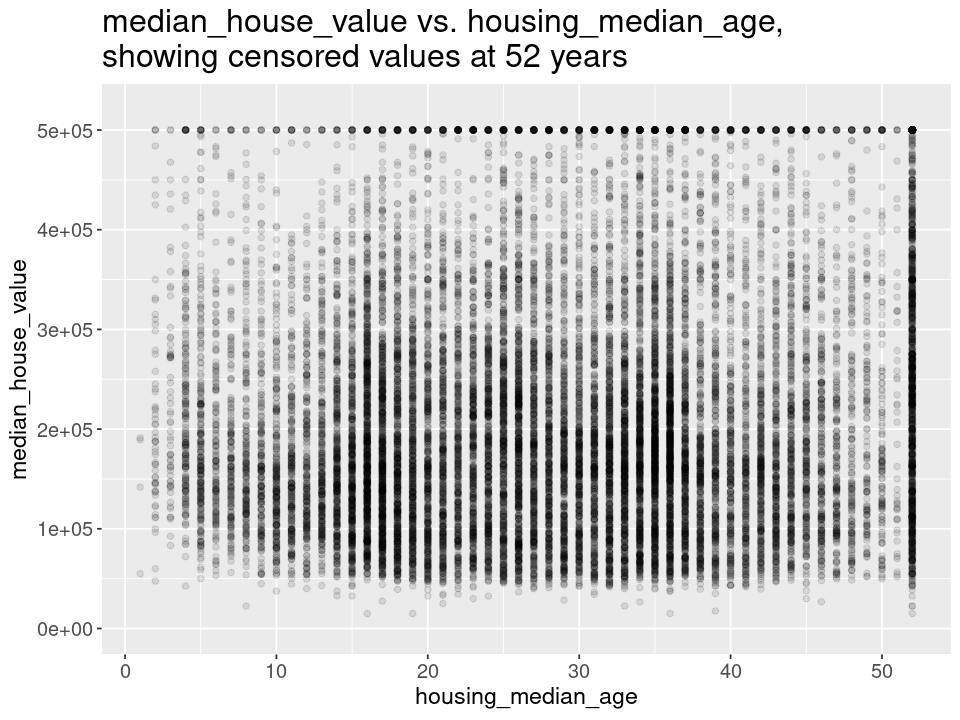

In [4]:
# Plot of median_house_value vs. housing_median_age. 
# 6.15% of the data is censored at age 52.
# median_house_value is also censored at 500K.

options(repr.plot.width= 8, repr.plot.height= 6)

p <- ggplot(dat, aes(housing_median_age, median_house_value)) +
  geom_point(alpha= 0.1) + xlab("housing_median_age") + ylab("median_house_value") +
  ggtitle("median_house_value vs. housing_median_age, 
showing censored values at 52 years") + ylim(0, 5.2e+05) +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
  
p

# We also see in the following plot that some of the median
# house values are censored.


In [5]:
# There are 1268 records, or districts, with a 
# censored housing_median_age.

nrow(dat[which(dat$housing_median_age >= 52),])


[1] 1268

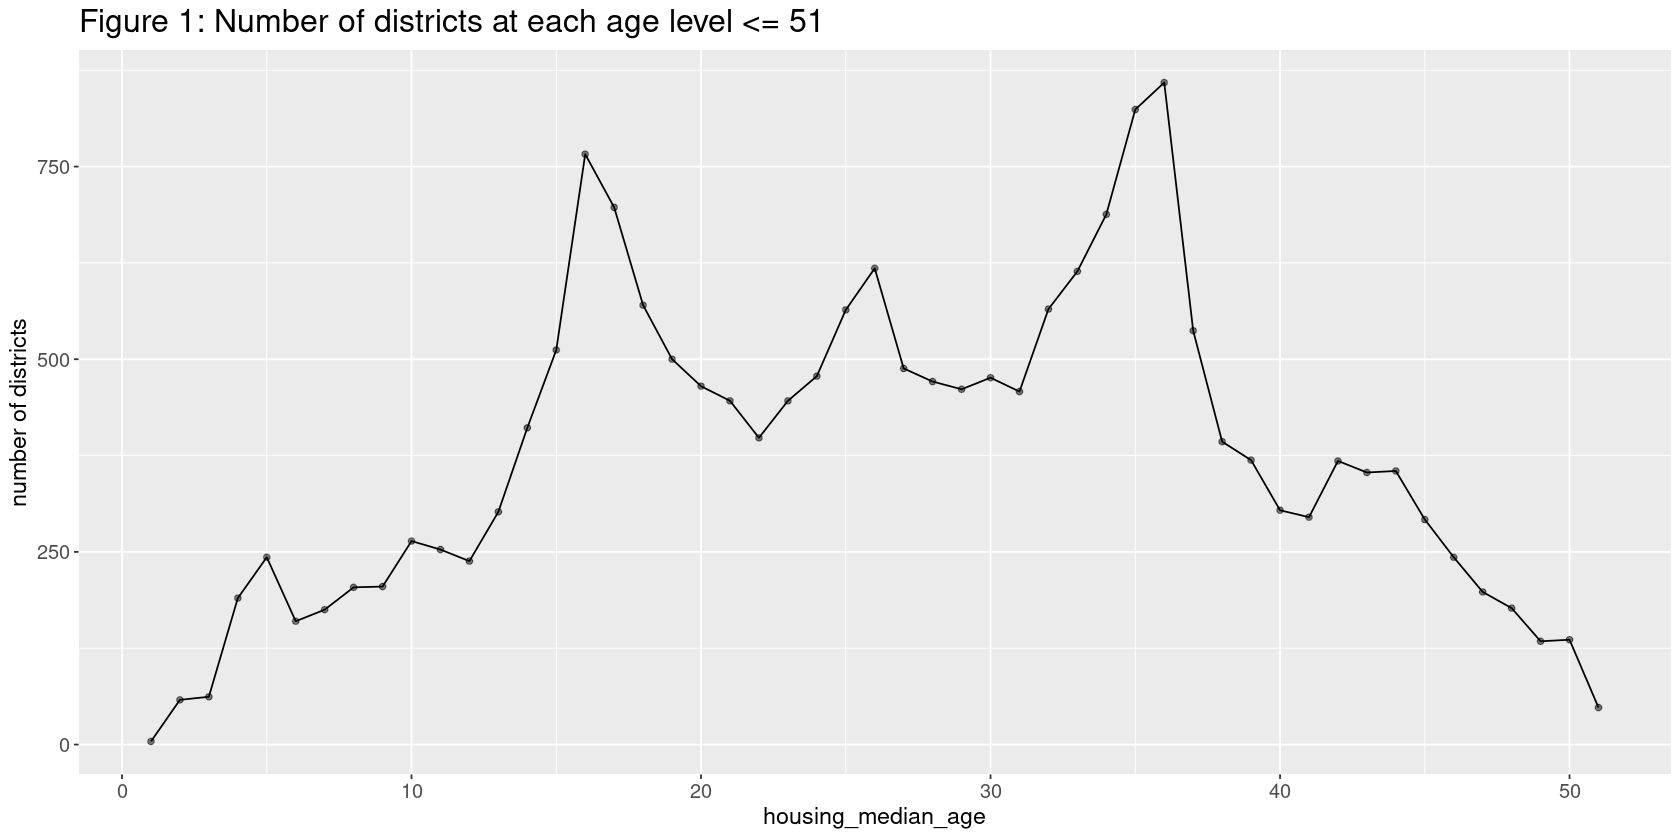

In [6]:
# Construct a dataframe for plotting the number of districts
# at each age level.  This will give us a very general idea
# of what the distribution of counts might look like for the
# 1268 records which need an imputed value.  We are particularly
# interested in the trend in the counts as age increases (e.g.,
# for age > 35).

ans <- table(as.factor(dat$housing_median_age))[1:51]
df_age <- rep(NA, 2 * length(ans))
dim(df_age) <- c(length(ans), 2)
df_age <- as.data.frame(df_age)
colnames(df_age) <- c("age", "count")
df_age$age <- as.numeric(names(ans))
df_age$count <- as.numeric(ans)


options(repr.plot.width= 14, repr.plot.height= 7)

p <- ggplot(df_age, aes(age, count)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + ylab("number of districts") +
  geom_line() +
  ggtitle("Figure 1: Number of districts at each age level <= 51") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [7]:
tail(df_age)


,age,count
,<dbl>,<dbl>
46,46,243
47,47,198
48,48,177
49,49,134
50,50,136
51,51,48


In [8]:
round(sd(df_age$count),1)


[1] 203.3

## Hypothesized distribution for the actual, unobserved values

In [9]:
# Creating an example distribution beyond age 51 will help us
# get a sense of what predictions are plausible for the
# mean of the true, unobserved ages beyond age 51.
# See plot that follows.

# Possible counts for ages 52:82.  We expect the counts
# to decrease as we move further to the right.  The first
# distribution (hypdist vector) has a smaller mean and median.
# hypdist <- c(130, 125, 120, 112, 108, 100, 93, 80, 73, 66,
#             60, 49, 40, 35, 30, 22, 15, 0, 0, 5, 0, 0, 3,
#             0, 0, 0, 1, 0, 0, 0, 1)
hypdist <- c(120, 110, 100, 105, 100, 90, 85, 80, 81, 71,
            65, 54, 45, 35, 30, 32, 25, 15, 5, 5, 3, 2, 3,
            0, 2, 2, 1, 1, 0, 0, 1)
sum(hypdist)
# 1268

observed <- as.numeric(df_age[which(df_age$age >= 22),]$count)

all <- c(observed, hypdist)
n <- length(22:82)

dftmp <- rep(NA, 2 * n)
dim(dftmp) <- c(n, 2)
dftmp <- as.data.frame(dftmp)
colnames(dftmp) <- c("age", "count")
dftmp$age <- 22:82
dftmp$count <- all


[1] 1268

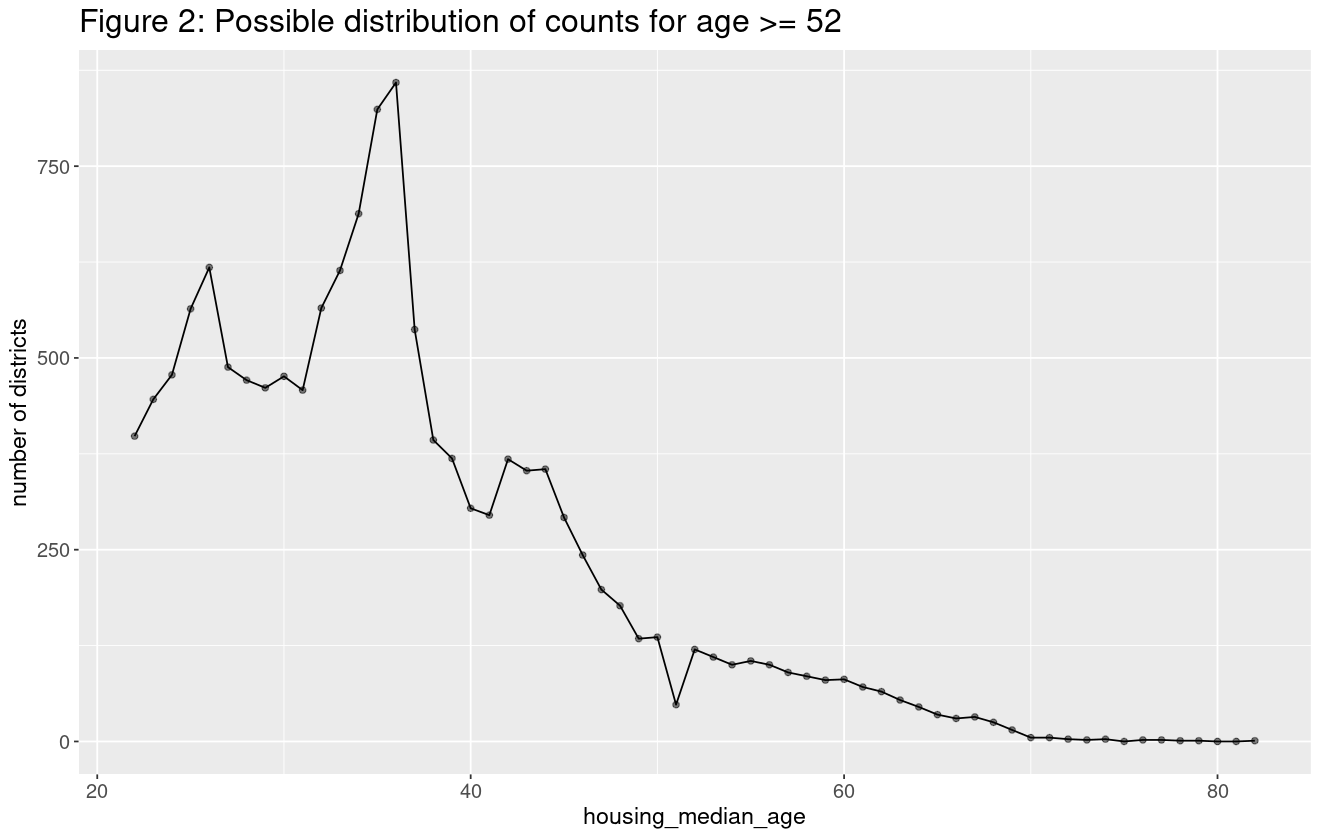

In [10]:
# Plot to show possible distribution of 1268 districts 
# beyond age 51.

options(repr.plot.width= 11, repr.plot.height= 7)

p <- ggplot(dftmp, aes(age, count)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + ylab("number of districts") +
  geom_line() +
  ggtitle("Figure 2: Possible distribution of counts for age >= 52") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [11]:
# The sharp drop in the counts from ages 36 to 51 suggests
# that the counts from age 52 on will drop even more quickly
# than what is shown in the above plot.  E.g., if nearly all
# of the 1268 censored districts have ages <= 63, then the 
# mean and median shown here (58.4 and 58 respectively) are
# likely too high. 

round(sum(hypdist * 52:82)/sum(hypdist), 1)
# 58.4
round(median(rep(52:82, hypdist)), 1)
# 58


[1] 58.4

[1] 58


 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71 
120 110 100 105 100  90  85  80  81  71  65  54  45  35  30  32  25  15   5   5 
 72  73  74 
  3   2   3 

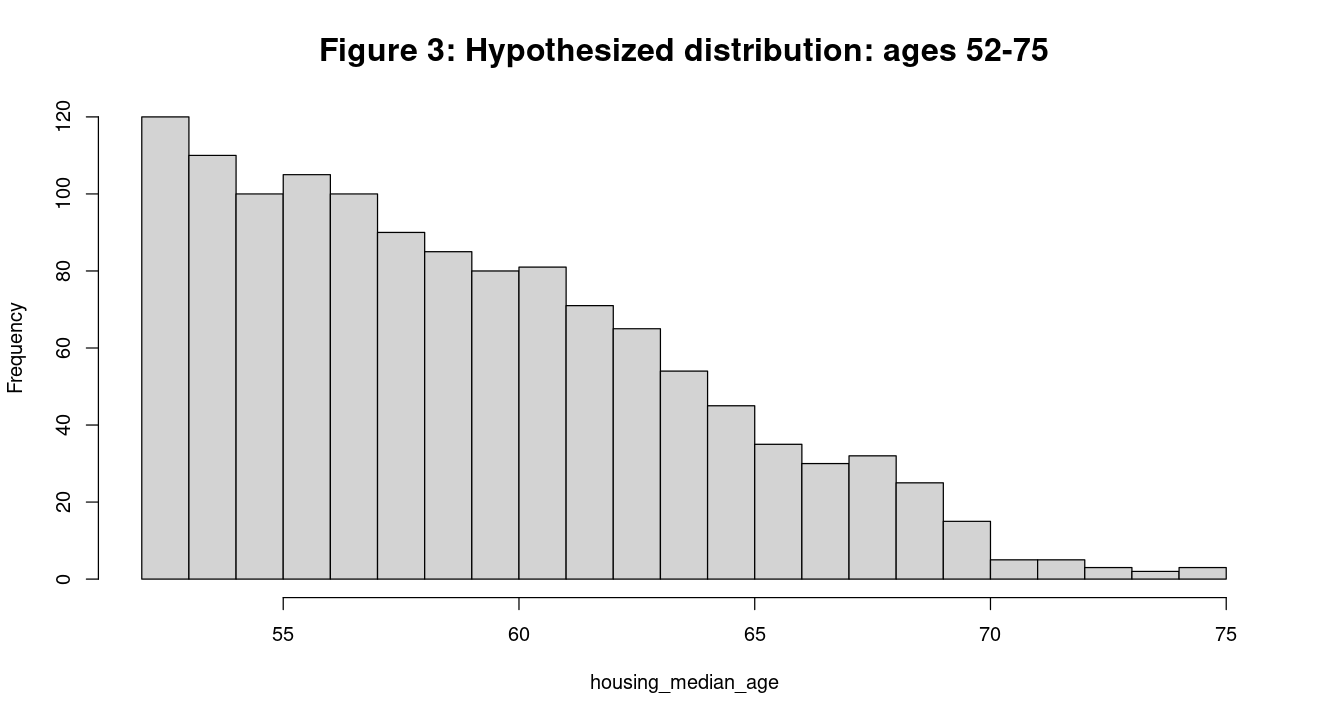

In [12]:
# The histogram below shows the counts for hypdist; this
# is a close-up of the far right of Figure 2.

tbl <- table(as.factor(rep(52:75, hypdist[1:24]))); tbl

options(repr.plot.width= 11, repr.plot.height= 6)

# Add 0.02 to each of the ages so that the histogram
# looks right.
hist(rep(52:75, hypdist[1:24]) + 0.02, breaks=18, xlab="housing_median_age",
     main="Figure 3: Hypothesized distribution: ages 52-75", cex.main=1.6)


In [ ]:
### COMMENTS for Figures 1, 2, and 3:

############################################################# 

# In Figure 1 above, from age 36 onwards, the trend is
# a very sharp drop in the counts.  For age 52 and beyond, 
# the number of districts we would expect to see for each
# age level is < 177, more likely < 140.  That number is 
# likely to decrease relatively quickly as age increases 
# beyond 52.  I have tried to capture one plausible
# scenario for the tailing off of the counts; this is
# shown in Figures 2 and 3.

# The sharp drop in the counts from age 36 onwards is something
# to keep in mind when predicting the mean of the counts for 
# ages > 51.
# There are 1268 districts with an age >= 52.

# The above example distribution is an important reference.
# It provides us with our first prediction for the mean.

#############################################################



## Get a 2nd prediction for the mean using shift increment ratios

We can obtain a second prediction for the mean of the actual, unobserved age values by utilizing what I will call "shift-increment" ratios.  The ratios are computed by looking out a certain distance from a cell (bin) floor, taking the mean of the values found in this interval or window, and then dividing by the value of the cell floor.  The ratio is computed for most of the bins below the cap.  I allow the last few windows to overlap with the hypothesized distribution; I stop when up to about one-third of the data for a given ratio comes from the hypothesized distribution.  A model of the series of ratios is then used to predict the mean of the actual, unobserved values in the range of imputation.

Why get a second prediction for the mean?  This second prediction is largely based on the data below the cap rather than the hypothesized distribution alone; so it helps us to confirm the first prediction.  Because the first prediction takes precedence and is used to help us judge the plausibility of the second, model-based prediction, the  confirmation we get is not assumption-free.  Rather, it is a check for consistency---seeing whether the data we have for the variable, the data below the cap, is *consistent* with our first prediction for the mean.  Also, the second prediction is valuable in that it provides us with a prediction interval, i.e., a measure of the uncertainty of our prediction, per the data used to make the prediction.


For the first set of ratios below, I look out 1.6 times (1.6X) the value of the starting point, or cap.  The multiplier of 1.6 is used because it captures most of the expected imputation range.  (Note that 1.6 * 52 = 83, and 83 is my expected upper limit for the imputation range.)  For example, if we artificially capped our data at year 32, I am interested in the mean and median of the counts in the range \[32, 51\].  As we will see in what follows, the 1.6X ratios are not nearly as helpful as the 31-year ratios.  (31 + 52 = 83; we do not need to make the span 31 years, but when we make it so, we capture the entire expected range for the imputed values capped at age 52.)  Using the 31-year ratios, we can make a fairly good (second) prediction for the mean of the actual, unobserved values with an age >= 52.  We can then use this prediction to help us improve upon the Gibbs sampler output when imputing values for the records with a censored housing_median_age.

The 1.6X ratios are presented primarily for pedagogic purposes.  This series of ratios helps us see just how much better the 31-year ratios are for the age data we are working with.  (The difference is not so great when we work with the median house values in Appendix B.)

We see below that getting a good second prediction for the median is much harder.  I end up abandoning this effort.  We know from the hypothesized distribution that the median should be less than the mean, and the hypothesized distribution gives us an estimate of what the difference is.  We just won't have a prediction interval.

Compare the imputation done below with that in Appendix B.  In Appendix B I learn that the size of the moving window is far more important than I first realized.  The larger we make the span, the larger our ratios; this in turn means that if the span is too large for each of the computed ratios we rely on for making our prediction at age 52, then our prediction will be too large.  (This problem would not arise if we were able to use the 1.6X ratios but, again, modeling the 1.6X ratios can be much more difficult.  If we do it right, we will get a much more accurate prediction, in general, by using a sliding window that does not change in size.)  Fortunately, this does not happen here, for we obtain a prediction (mean = 57) that is consistent with that from our hypothesized distribution (mean = 58).  In fact, for the age data, the prediction of the mean is not affected by the size of the window nearly as much as with the median house values in Appendix B.  (Using 15-year windows for the age data, I get an estimate for the mean within 0.5 year of the current estimate.)


                                    * * * * *



In [13]:
# Combine the counts from the hypothesized distribution with the
# counts <= age 51.  

all_age_vals <- c(dat[which(dat$housing_median_age <= 51), c("housing_median_age")],
                        rep(52:82, hypdist))
(all_counts <- table(as.factor(all_age_vals)))



  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  4  58  62 190 243 160 175 204 205 264 253 238 302 411 512 766 697 570 500 465 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
446 398 446 478 564 618 488 471 461 476 458 565 614 688 824 859 537 393 369 304 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
295 368 353 355 292 243 198 177 134 136  48 120 110 100 105 100  90  85  80  81 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  76  77  78  79  82 
 71  65  54  45  35  30  32  25  15   5   5   3   2   3   2   2   1   1   1 

In [14]:
mean_ratios <- median_ratios <- rep(NA, length(1:40))
means <- medians <- rep(NA, length(1:40))
rcd_count <- rep(NA, length(1:40))


# We look out 1.6X the value of the cap.  Why 1.6 when 1.6*52
# is only 83 and there might be a few districts with a
# housing median age > 83?  There are three reasons: (i) the
# more we increase the span, the fewer datapoints we have to
# work with for understanding the pattern/trajectory of the 
# means and medians; the larger the span the fewer the datapoints
# because we run into the hypothesized distribution more quickly;
# and (ii) the further out we set the upper limit, the larger the
# standard errors are for the imputed values; the large standard 
# errors are not helpful when we expect < 1% of the true, 
# unobserved ages for the 1268 records to be > 83;
# this expectation ought to be incorporated into the  imputation
# process; and (iii) even if 83 is a bit too low for the upper 
# limit, this will affect the mean of the distribution in the 
# range of imputation but not the median, given the small number
# of districts we expect to find beyond this upper limit.  This 
# is why we also want to collect information on the medians,
# assuming we can get good information on the medians.

span <- 1.6

for(cur_age in 1:40) {
    
    agevals <- all_age_vals[which((all_age_vals >= cur_age) &
                                  (all_age_vals < round(span*cur_age)))]
    rcd_count[cur_age] <- length(agevals)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age] <- round(age_mean/cur_age, 3)
    means[cur_age] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age] <- round(age_median/cur_age, 3)
    medians[cur_age] <- age_median
}

paste0("These are the 1.6X shift increments for the means: ")
names(mean_ratios) <- as.character(1:40)
print(mean_ratios)


df_ratios <- rep(NA, 6*length(mean_ratios))
dim(df_ratios) <- c(length(mean_ratios), 6)
df_ratios <- as.data.frame(df_ratios)
colnames(df_ratios) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_ratios$age <- 1:40
df_ratios$rcds <- rcd_count
df_ratios$mean_ratio <- mean_ratios
df_ratios$median_ratio <- median_ratios
df_ratios$mean <- means
df_ratios$median <- medians


[1] "These are the 1.6X shift increments for the means: "

    1     2     3     4     5     6     7     8     9    10    11    12    13 
1.000 1.000 1.251 1.140 1.176 1.268 1.237 1.262 1.237 1.295 1.347 1.301 1.285 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
1.243 1.239 1.256 1.259 1.280 1.268 1.279 1.297 1.288 1.311 1.292 1.284 1.275 
   27    28    29    30    31    32    33    34    35    36    37    38    39 
1.263 1.261 1.244 1.234 1.222 1.203 1.191 1.180 1.178 1.185 1.191 1.197 1.190 
   40 
1.190 


In [15]:
df_ratios <- df_ratios[4:40,]
summary(df_ratios$rcds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    433    3964    5335    5208    7704    8420 

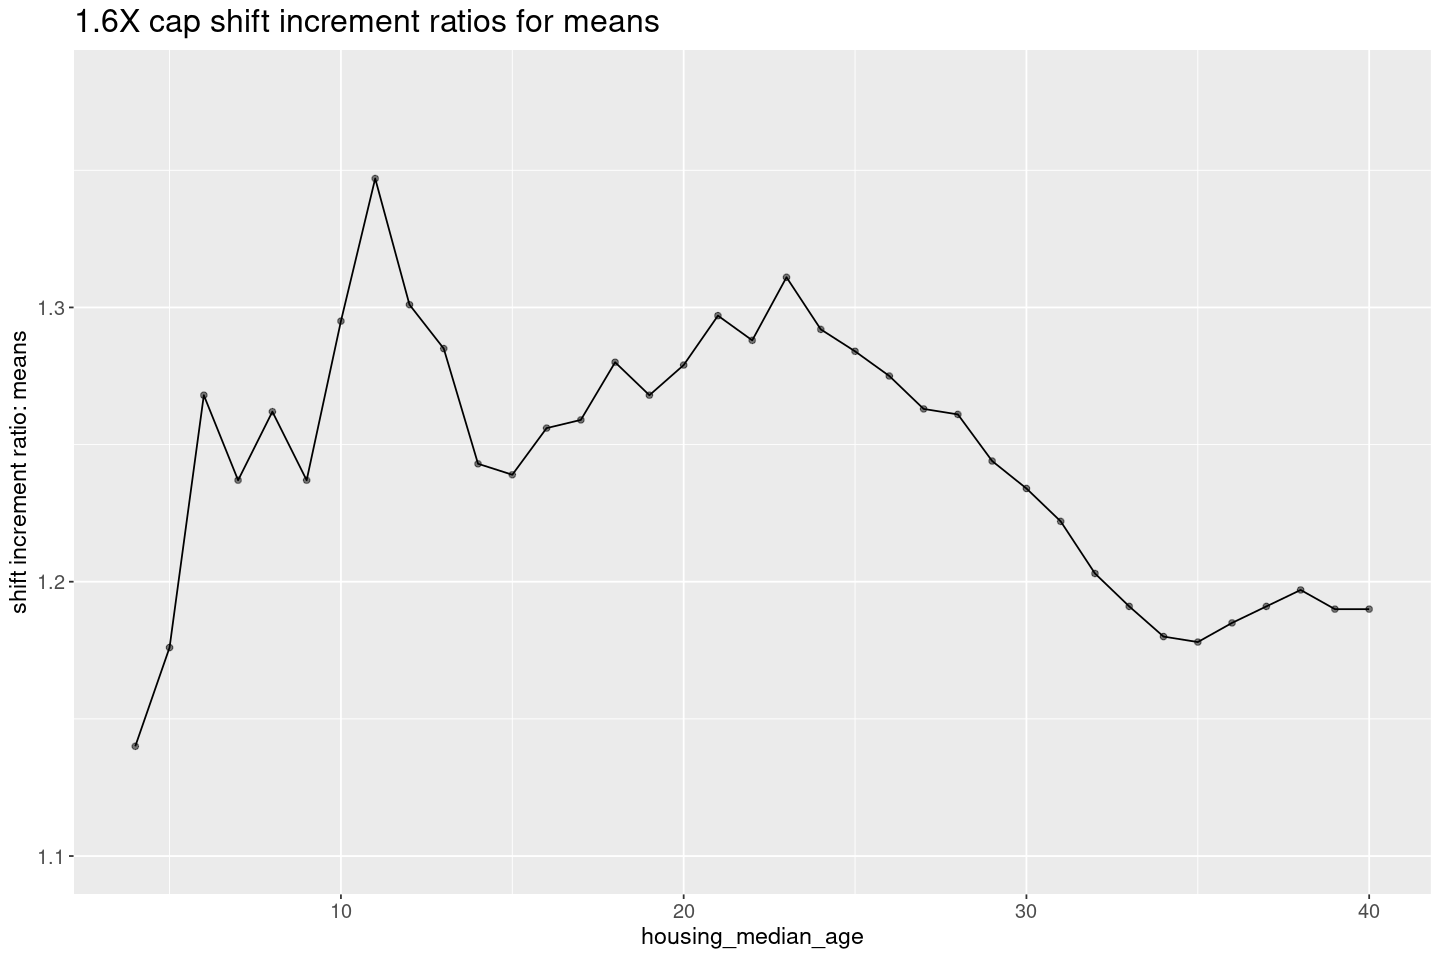

In [16]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_ratios, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("shift increment ratio: means") +
  geom_line() + ylim(1.1, 1.38) +
  ggtitle("1.6X cap shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENTS:

# The plot for the means shows a strong downward trend when 
# the cap is >= 23.  The numbers suggest that the shift 
# increment ratio for the range [52, 83] will be > 1
# and < 1.2.  The ratio can never be < 1.

# The shift increment ratio for age 32 is 1.203.  The corres-
# ponding ratio for age 52 will almost certainly be < 1.2 due
# to the overall downward trend after age 23.  Notice that 
# 1.2 * 52 = 62.4.  For the hypothesized distribution, the 
# mean is at 58.


In [17]:
# Check median ratios.

paste0("These are the 1.6X shift increments for the medians: ")
names(median_ratios) <- as.character(1:40)
print(median_ratios[4:40])


[1] "These are the 1.6X shift increments for the medians: "

    4     5     6     7     8     9    10    11    12    13    14    15    16 
1.250 1.200 1.333 1.286 1.250 1.222 1.300 1.364 1.333 1.308 1.214 1.200 1.250 
   17    18    19    20    21    22    23    24    25    26    27    28    29 
1.235 1.278 1.263 1.300 1.286 1.273 1.348 1.333 1.320 1.308 1.259 1.250 1.241 
   30    31    32    33    34    35    36    37    38    39    40 
1.200 1.194 1.156 1.152 1.147 1.143 1.167 1.162 1.158 1.154 1.150 


In [ ]:
### COMMENTS:

# For ages 32 and up, the median ratios are smaller than the
# corresponding ratios for the means.  This is what we expect to see.

# The trend from age 23 onwards in the above plot is not easy to
# model in a way that permits us to get an accurate prediction at
# age 52.  It is much easier to work with the 31-year ratios below.


### Use a 31-year span for computing shift-increment ratios

Instead of looking out 1.6X the age level, we can use a sliding window with a span of 31 years.  (I use 31 for the span because 52 + 31 = 83 and 1.6 * 52 = 83 and 83 is about as far out as I think the predictions ought to go.  Also, I need to look out far enough to have stable measures of the mean and median.)  In the following I slide the 31-year window up to age 30, meaning that I make use of part of the hypothesized distribution in the imputation range.  Making partial use of the hypothesized distribution is likely to give us more accurate predictions of the mean and median as long as our hypothesized distribution roughly resembles the distribution of the actual, unobserved values.

This second method is a way to confirm the predictions we already have from the hypothesized distribution itself.  Importantly, this second method provides us with a prediction interval, i.e., a sense of the accuracy of our prediction.  The prediction interval we obtain should cover the prediction we have from the hypothesized distribution.  If it does not, we have to adjust the window size used to compute the ratios until the interval does cover the prediction we have based on the hypothesized distribution alone.



                                    * * * * *

In [18]:
# Get means and medians of the age values, looking out 31 years. 

mean_ratios <- median_ratios <- rep(NA, length(5:30))
means <- medians <- rep(NA, length(5:30))
rcd_count <- rep(NA, length(5:30))

span <- 31
for(cur_age in 5:30) {
    
    agevals <- rep(cur_age:(span + cur_age), 
                   as.numeric(all_counts[cur_age:(span + cur_age)]))
    rcd_count[cur_age - 4] <- length(agevals)
    
    # Compute mean.
    age_mean <- round(mean(agevals), 5)
    mean_ratios[cur_age - 4] <- round(age_mean/cur_age, 3)
    means[cur_age - 4] <- age_mean

    # Compute median.
    age_median <- round(median(agevals), 5)
    median_ratios[cur_age - 4] <- round(age_median/cur_age, 3)
    medians[cur_age - 4] <- age_median
}

paste0("These are the 31-year shift increments for the means: ")
names(mean_ratios) <- as.character(5:30)
print(mean_ratios)


df_rat02 <- rep(NA, 6*length(mean_ratios))
dim(df_rat02) <- c(length(mean_ratios), 6)
df_rat02 <- as.data.frame(df_rat02)
colnames(df_rat02) <- c("age", "rcds","mean","median","mean_ratio","median_ratio")
df_rat02$age <- 5:30
df_rat02$rcds <- rcd_count
df_rat02$mean_ratio <- mean_ratios
df_rat02$median_ratio <- median_ratios
df_rat02$mean <- means
df_rat02$median <- medians


[1] "These are the 31-year shift increments for the means: "

    5     6     7     8     9    10    11    12    13    14    15    16    17 
4.662 4.015 3.519 3.147 2.854 2.619 2.439 2.286 2.156 2.045 1.951 1.873 1.817 
   18    19    20    21    22    23    24    25    26    27    28    29    30 
1.763 1.709 1.652 1.603 1.558 1.514 1.476 1.442 1.415 1.391 1.365 1.341 1.317 


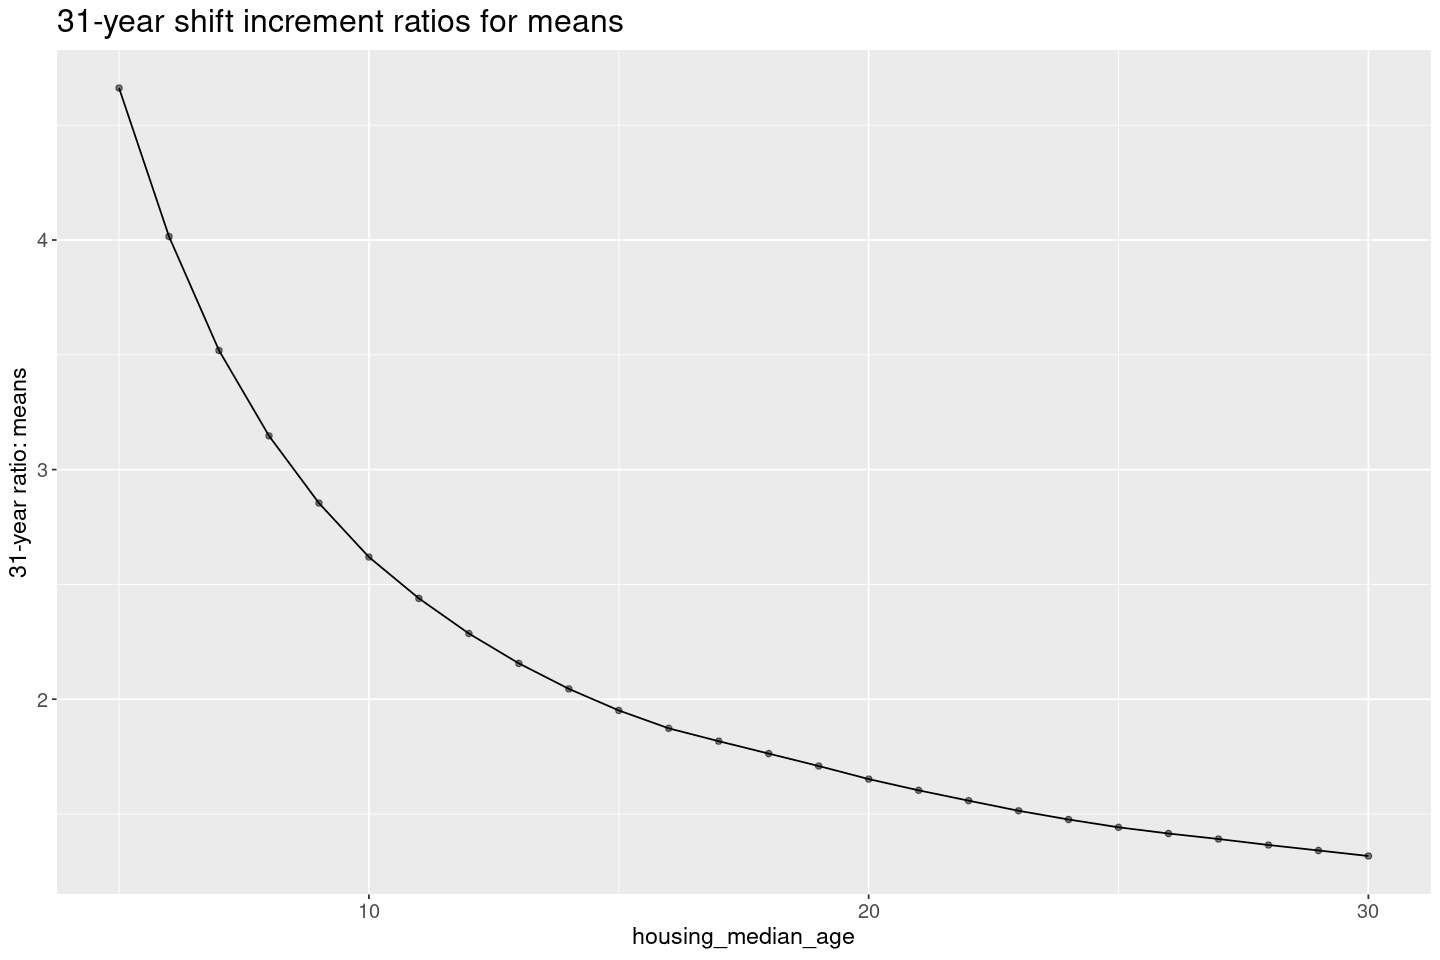

In [19]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat02, aes(age, mean_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("31-year ratio: means") +
  geom_line() +
  ggtitle("31-year shift increment ratios for means") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [20]:
# The variance in the counts is not extreme.  Even so, 
# we get a better model below if we take into account 
# these differences.

df_rat02$rcds


[1] 14819 15113 15346 15540 15640 15730 15834 15934 16051 16041 15873 15559
[13] 14970 14407 13973 13521 13176 12840 12542 12201 11823 11349 10816 10408
[25] 10018  9628

In [26]:
# Model for predicting mean_ratio at age = 52.  If we use
# rcds as a term in the model, the model wants both the 
# quadratic and cubic of rcds.  This will give us wild 
# prediction values at age 52, since 52 is so far beyond
# the range of the data from which our model is constructed.
# Using WLS works much better here than using polynomials

g03 <- lm(I(mean_ratio^0.19) ~ I(age^0.03) + I((age^0.03)^2), 
          data= df_rat02, weights=(df_rat02$rcds)^0.8)
ans <- summary(g03)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-0.0664 -0.0441 -0.0185  0.0439  0.1157 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)       50.786      1.094    46.4   <2e-16
I(age^0.03)      -87.092      2.026   -43.0   <2e-16
I((age^0.03)^2)   38.093      0.938    40.6   <2e-16

Residual standard error: 0.0565 on 23 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 5.09e+04 on 2 and 23 DF,  p-value: <2e-16


In [27]:
ncvTest(g03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.00062782, Df = 1, p = 0.98

In [28]:
residualPlots(g03, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(age^0.03)         -0.38             0.70
I((age^0.03)^2)     -0.51             0.61
Tukey test           0.52             0.60


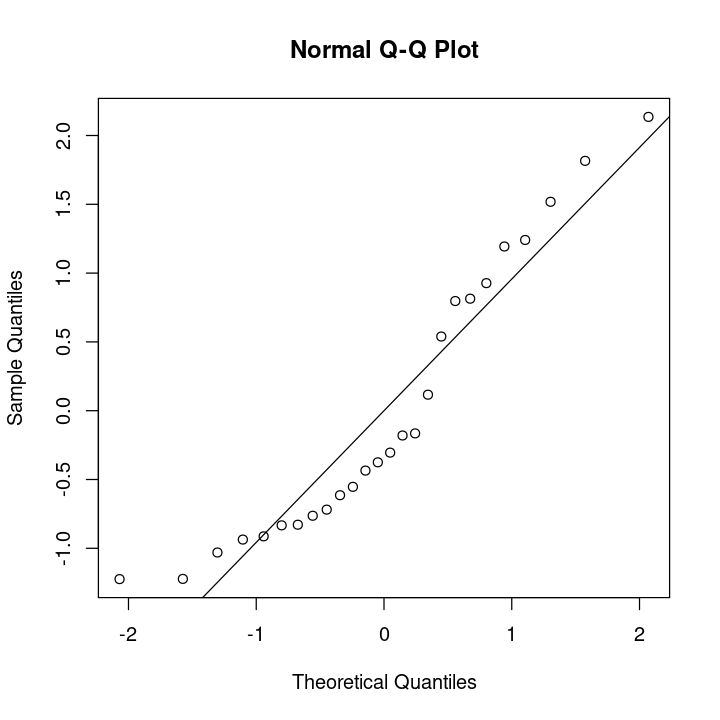

In [29]:
# The q-q plot below looks good but not great. The
# better this plot is, the more we can trust our 
# prediction for the mean.

options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g03, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [30]:
# Prediction for mean when age = 52.

newdat <- data.frame(age=52, rcds=1268)

ans <- predict.lm(g03, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.19); ans_transf
# 1.0971

# 1.0971 * 52 = 57.0 = 57


1 
1.0971

In [ ]:
### COMMENTS:

# The prediction looks plausible.  Our hypothesized distribution
# has a mean of 58.4.  The 95% prediction interval below covers
# the 58.4.  This helps validate the use of the 31-year window to
# obtain the ratios.  (As already noted, our model prediction will
# vary based on the window size used to compute the ratios.  The
# mean from the hypothesized distribution helps us know what window
# size to work with.)


In [31]:
# Compute a 95% prediction interval.

pred_ans <- predict.lm(g03, newdata= newdat, interval="prediction",
                       level=0.95, weights=1268^0.8)
pred_ans_transf <- pred_ans^(1/0.19); pred_ans_transf


,fit,lwr,upr
1,1.0971,1.0542,1.1413


In [32]:
lwr <- round(pred_ans_transf[2] * 52, 1)
upr <- round(pred_ans_transf[3] * 52, 1)

clause <- "95% prediction interval for estimate of the mean of the actual, unobserved values: "
print_ans <- paste0("[", lwr, ", ", upr ,"]")
paste0(clause, print_ans)
# [54.8, 59.3]


[1] "95% prediction interval for estimate of the mean of the actual, unobserved values: [54.8, 59.3]"

### Plot the 31-year shift increment ratios for the medians

In [33]:
paste0("These are the 31-year shift increments for the medians: ")
names(median_ratios) <- as.character(5:30)
print(median_ratios)


[1] "These are the 31-year shift increments for the medians: "

    5     6     7     8     9    10    11    12    13    14    15    16    17 
4.800 4.167 3.571 3.250 2.889 2.600 2.455 2.333 2.154 2.071 2.000 1.875 1.824 
   18    19    20    21    22    23    24    25    26    27    28    29    30 
1.778 1.737 1.650 1.619 1.545 1.478 1.458 1.400 1.385 1.333 1.286 1.276 1.233 


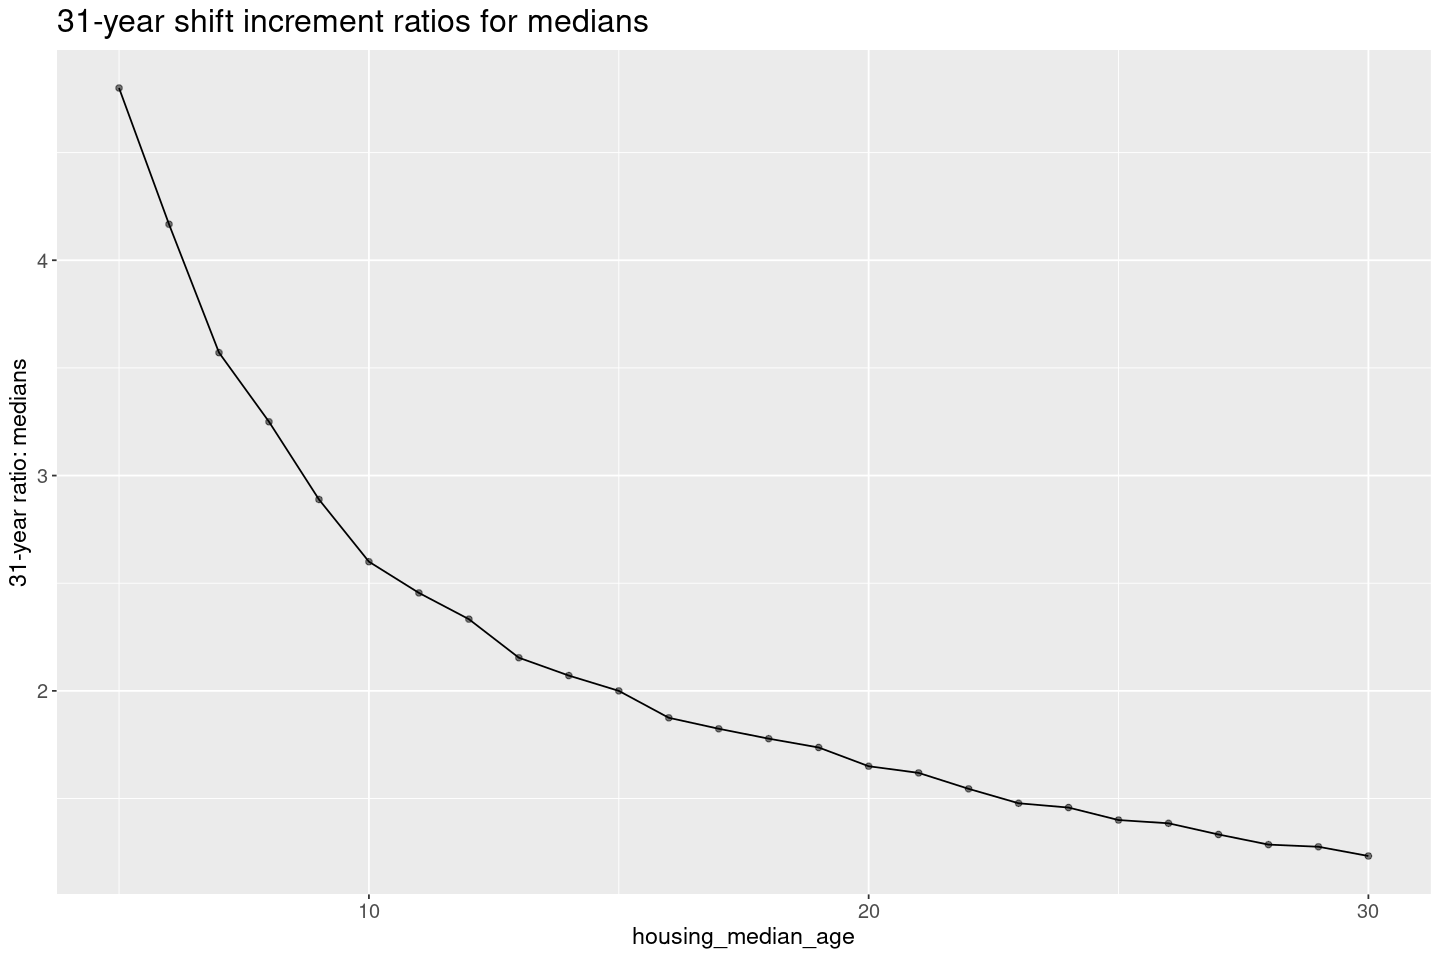

In [34]:
options(repr.plot.width= 12, repr.plot.height= 8)

p <- ggplot(df_rat02, aes(age, median_ratio)) +
  geom_point(alpha= 0.5) + xlab("housing_median_age") + 
  ylab("31-year ratio: medians") +
  geom_line() +
  ggtitle("31-year shift increment ratios for medians") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p

# Compared to the previous curve based on means, the following
# curve for the medians is less smooth.  This has to do with
# the way the medians are computed.  It is also what makes it
# much more difficult to get good model predictions for the
# median.


In [35]:
# Model for predicting median_ratio at age = 52.

g04 <- lm(I(median_ratio^0.28) ~ I(age^0.03) + I((age^0.03)^2), 
          data= df_rat02, weights=(df_rat02$rcds)^0.5)
ans <- summary(g04)
ans[[1]] <- ""; ans



Call:
""

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.14370 -0.03870 -0.00706  0.04074  0.12442 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)        78.90       5.50    14.3  5.9e-13
I(age^0.03)      -135.71      10.19   -13.3  2.7e-12
I((age^0.03)^2)    59.08       4.71    12.5  9.2e-12

Residual standard error: 0.0681 on 23 degrees of freedom
Multiple R-squared:  0.998,	Adjusted R-squared:  0.998 
F-statistic: 5.69e+03 on 2 and 23 DF,  p-value: <2e-16


In [36]:
ncvTest(g04)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.040897, Df = 1, p = 0.84

In [37]:
residualPlots(g04, plot=FALSE)


                Test stat Pr(>|Test stat|)
I(age^0.03)         -3.05           0.0059
I((age^0.03)^2)     -3.20           0.0042
Tukey test           0.01           0.9893


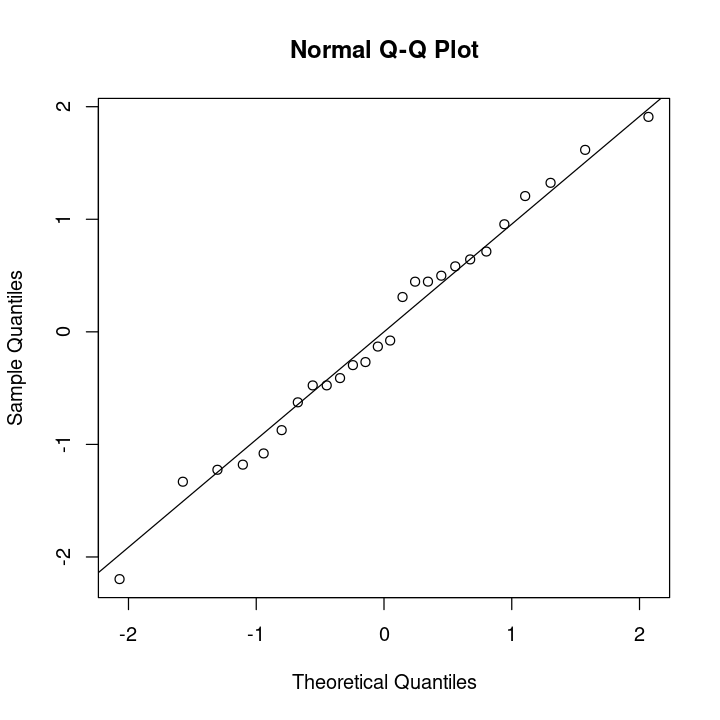

In [38]:
options(repr.plot.width= 6, repr.plot.height= 6)

ans <- qqnorm(scale(residuals(g04, type= "pearson")))
qqline(ans$x, probs = c(0.25, 0.75))


In [39]:
# Prediction for median when age = 52.

newdat <- data.frame(age=52, rcds=1268)

ans <- predict.lm(g04, newdata= newdat, type= "response")
ans_transf <- ans^(1/0.28); ans_transf
# 0.9995

# 0.9995 * 52 = 52


1 
0.99949

In [38]:
### COMMENTS:

# The g04 prediction is not plausible.  While we expect the
# median to be less than the mean (predicted to be 57), we
# have a median of 58 for the hypothesized distribution, and
# so we do not expect the median to be as low as 52.  However,
# the 95% prediction interval below almost captures the 58
# estimate.


In [40]:
# Compute a 95% prediction interval for the median prediction.

pred_ans <- predict.lm(g04, newdata= newdat, interval="prediction",
                       level=0.95, weights=1268^0.5)
pred_ans_transf <- pred_ans^(1/0.28); pred_ans_transf


,fit,lwr,upr
1,0.99949,0.89653,1.1107


In [41]:
lwr <- round(pred_ans_transf[2] * 52, 1)
upr <- round(pred_ans_transf[3] * 52, 1)

clause <- "95% prediction interval for estimate of the median of the actual, unobserved values: "
print_ans <- paste0("[", lwr, ", ", upr ,"]")
paste0(clause, print_ans)
# [52, 57.8]


[1] "95% prediction interval for estimate of the median of the actual, unobserved values: [46.6, 57.8]"

### Revised hypothesized distribution

If we believe the mean is somewhat less than 58, we should make adjustments to the counts of our hypothesized distribution until we bring the mean closer to 57.  It is important to see what change in the shape of the distribution is required to make this happen.

The g03 model above has very good diagnostics.  We can change the window size quite a bit, model with a variant of g03, and get very much the same estimate for the mean.  Accordingly, I believe the mean is closer to 57 than 58.  Keep in mind that I want a mean for the vast majority of the actual, unobserved values.  Thus, I am not concerned with extreme outliers that might have an inordinate effect on the mean.

In [14]:
# One way to bring the mean in is to shorten the tail of the
# distribution.  Here I end the distribution at age 73; the
# previous distribution went to age 82.

# If we maintain monotonically decreasing counts, the counts
# for ages 52 and 53 need to be fairly high relative to the 
# counts for ages 49-51.  Since I do not want to increase
# these first counts any further, and since I want to maintain
# the monotonicity, I settle for an adjusted mean of 57.6
# rather than something closer to 57.


hypdist <- c(140, 131, 126, 116, 107, 93, 85, 80, 71, 61,
             55, 45, 40, 35, 30, 22, 12, 8, 5, 3, 2, 1)
sum(hypdist)

round(sum(hypdist * 52:73)/sum(hypdist), 1)
# 57.6
round(median(rep(52:73, hypdist)), 1)
# 57


[1] 1268

[1] 57.6

[1] 57

In [15]:
length(hypdist)


[1] 22


 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71 
140 131 126 116 107  93  85  80  71  61  55  45  40  35  30  22  12   8   5   3 
 72  73 
  2   1 

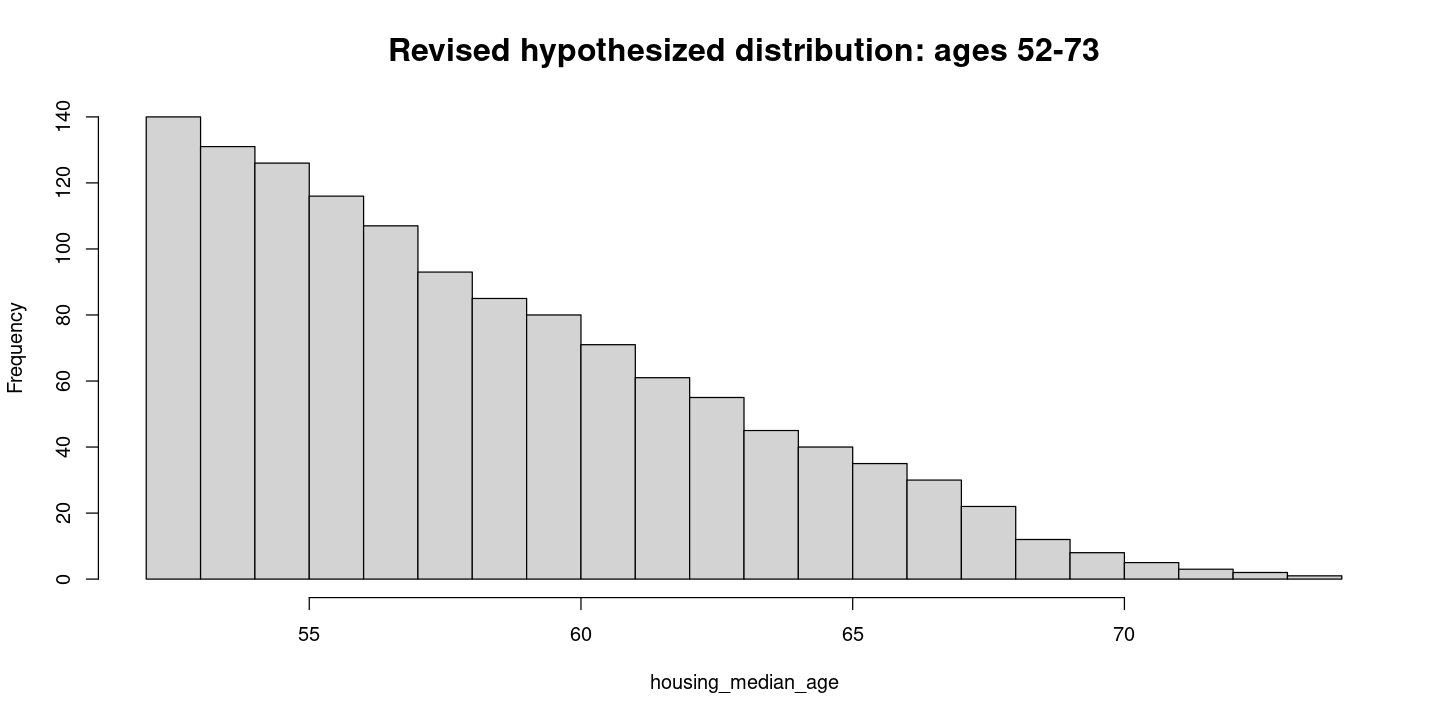

In [16]:
# Revised hypothetical distribution, based on model g03 
# prediction.  There are 22 bins.

tbl <- table(as.factor(rep(52:73, hypdist[1:22]))); tbl

options(repr.plot.width= 12, repr.plot.height= 6)

# Add 0.02 to each of the ages so that the histogram
# looks right.
hist(rep(52:73, hypdist[1:22]) + 0.02, breaks=18, xlab="housing_median_age",
     main="Revised hypothesized distribution: ages 52-73", cex.main=1.6)


In [ ]:
### COMMENT:

# Since housing median ages reflect historical circumstances
# in the state of California, the distribution of the actual,
# unobserved values could be quite different from the shape
# we see above.  But if that is so, it is surprising that the
# age data was censored at 52 and not further out.  The above
# hypothesized distribution merely continues the trend we
# see in Figures 1 and 2 between ages 36 and 51.  Also, we
# know that the counts will have to taper off to 0 and will
# likely do so relatively quickly.


## Final Comments for Section 1

For the imputation process that follows, having a good prediction for the mean is important.  From the above we can be fairly confident that the mean of the true, unobserved district ages is <= 60 and the median is <= 59.  We can be fairly confident that the median will be less than the mean.  The mean is likely to be between 55 and 59; our current working prediction is that the mean is around **57.6**.  The median is likely to be between 53 and 58.  We do not have a good prediction for the median by way of modeling the data.

I have tried different approaches for getting a better prediction for the median (e.g., by increasing the window span and by going further into the hypothesized distribution), but to no avail.  The estimate is always below 1.  Thus, in what follows I focus only on the mean.



                                      * * * * *

# Section 2: Impute values for censored ages

This section complements the material in Section 2 of Part01.



In [ ]:
# Continue to use dat from Section 1 above.  6.15% of the
# records in dat have a censored housing median age.


In [17]:
colnames(dat)
summary(dat$housing_median_age)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    28.6    37.0    52.0 

In [201]:
# This is the model from Section 2, Part01 that we want 
# to use for imputing age values.

a03 <- lm(housing_median_age ~ 

            I(long_transf^-1) +
            I(long_transf^-1.5) +
          
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
          
            I(households^0.55) +
            I(households^1.1) +
          
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
          
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
          data= dat, weights= dat$households^0.55)

## REMINDER: dat has censored housing_median_age values.

a03.summary <- summary(a03); 
a03.summary[[1]] <- ""; a03.summary



Call:
""

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-229.00  -36.97    1.64   35.26  239.57 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)
(Intercept)                -8.92e+04   5.71e+03   -15.6   <2e-16
I(long_transf^-1)           4.43e+02   1.78e+01    24.9   <2e-16
I(long_transf^-1.5)        -4.93e+02   2.13e+01   -23.1   <2e-16
latitude                    9.73e+03   6.28e+02    15.5   <2e-16
I(latitude^2)              -3.97e+02   2.59e+01   -15.3   <2e-16
I(latitude^3)               7.19e+00   4.73e-01    15.2   <2e-16
I(latitude^4)              -4.88e-02   3.23e-03   -15.1   <2e-16
I(households^0.55)         -6.26e-01   1.96e-02   -31.9   <2e-16
I(households^1.1)           2.73e-03   2.15e-04    12.7   <2e-16
I(median_house_value^0.48)  2.69e-01   1.05e-02    25.7   <2e-16
I(median_house_value^0.24) -1.04e+01   3.97e-01   -26.2   <2e-16
I(HHdens_ln^1.35)          -9.87e-01   7.66e-02   -12.9   <2e-16
I(HHdens_ln^2.7)           

In [202]:
ncvTest(a03)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.13688, Df = 1, p = 0.711

In [203]:
residualPlots(a03, plot=FALSE)


                           Test stat Pr(>|Test stat|)
I(long_transf^-1)              -6.43          1.3e-10
I(long_transf^-1.5)            -6.53          6.7e-11
latitude                      -10.83          < 2e-16
I(latitude^2)                  -9.83          < 2e-16
I(latitude^3)                  -8.94          < 2e-16
I(latitude^4)                  -8.36          < 2e-16
I(households^0.55)             -8.07          7.2e-16
I(households^1.1)               5.08          3.8e-07
I(median_house_value^0.48)     -5.82          5.9e-09
I(median_house_value^0.24)     -7.61          2.8e-14
I(HHdens_ln^1.35)               7.57          3.8e-14
I(HHdens_ln^2.7)                5.70          1.2e-08
Tukey test                      0.05             0.96


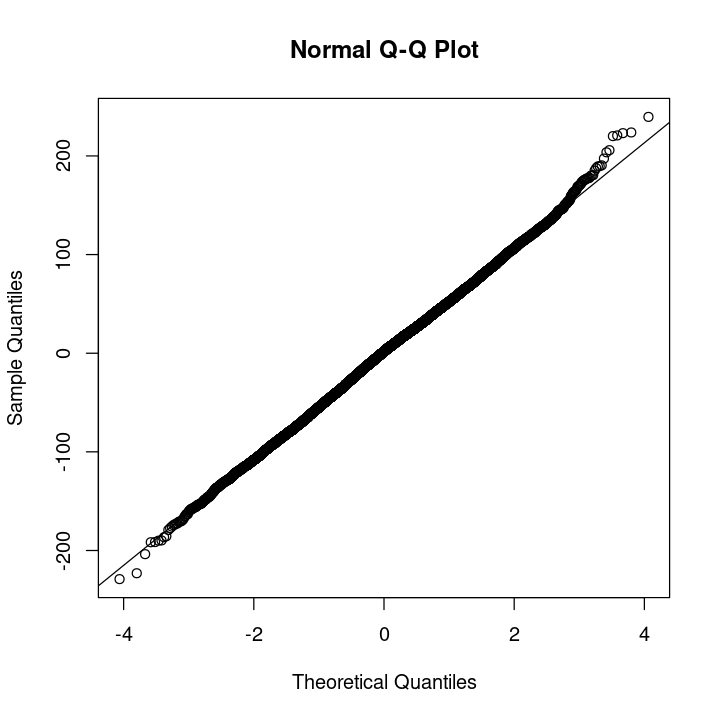

In [204]:
options(repr.plot.width= 6, repr.plot.height= 6)

qqnorm(residuals(a03, type= "pearson"))
qqline(residuals(a03, type= "pearson"))


In [18]:
# The value we assign to the upper limit is important.  The
# aim is to have an imputation range that captures most of
# the ages we would expect to find.  If we expand the range 
# too much, the quality of the imputed values (measured in
# terms of how close, on average, they are to the actual
# values) will decrease.  The mean of the predictions from
# the Gibbs sampler will be about halfway between the lower limit
# and the upper limit.  With 75 as the upper limit, the mean
# should be around age 64.

# I use 75 (rather than, say, 82 or 78) for C_upper because
# of the limit we now have for the revised hypothetical 
# distribution.

C <- 52
censored <- dat$housing_median_age >= C

# Create an upper limit.
C_upper <- 75

# Create some crude starting values for our imputed ages.
n.censored <- sum(censored)
z <- ifelse(censored, NA, dat$housing_median_age)
z[censored] <- runif(n.censored, C, C_upper)


In [19]:
length(censored)
n.censored


[1] 20603

[1] 1268

In [20]:
rows_censored <- rownames(dat[which(dat$housing_median_age >= C),])
print(head(rows_censored)); print(tail(rows_censored))


[1] "3" "4" "5" "6" "7" "8"
[1] "20142" "20143" "20221" "20237" "20238" "20593"


In [21]:
# Function to draw from a constrained normal distribution.

rnorm.trunc <- function(n, mu, sigma, lo=-Inf, hi=Inf) {
    
    # We need mu to be at least the value of C in
    # order to prevent a return of Inf values.
    mu02 <- ifelse(mu < C, C, mu)
    
    p.lo <- pnorm(lo, mu02, sigma)
    p.hi <- pnorm(hi, mu02, sigma)
    u <- runif(n, p.lo, p.hi)
    return(qnorm(u, mu02, sigma))
}


In [27]:
# Create matrix X for the terms in our model.

X <- dat

X$long1 <- (X$long_transf)^-1
X$long2 <- (X$long_transf)^-1.5

X$lat2 <- (X$latitude)^2
X$lat3 <- (X$latitude)^3
X$lat4 <- (X$latitude)^4

X$hh1 <- (X$households)^0.55
X$hh2 <- (X$households)^1.10

X$median_hhval_1 <- (X$median_house_value)^0.24
X$median_hhval_2 <- (X$median_house_value)^0.48

X$HHdens_ln1 <- (X$HHdens_ln)^1.35
X$HHdens_ln2 <- (X$HHdens_ln)^2.7


X <- X[, c("long1","long2","latitude","lat2","lat3","lat4",
           "hh1","hh2","median_hhval_1","median_hhval_2",
           "HHdens_ln1","HHdens_ln2")]
intercept <- rep(1, nrow(dat))

init.colnames <- colnames(X)

X <- as.data.frame(cbind(intercept, X), col.names=c("intercept", init.colnames),
                   row.names=rownames(dat))
dim(X)
colnames(X)


[1] 20603    13

[1] "intercept"      "long1"          "long2"          "latitude"      
 [5] "lat2"           "lat3"           "lat4"           "hh1"           
 [9] "hh2"            "median_hhval_1" "median_hhval_2" "HHdens_ln1"    
[13] "HHdens_ln2"

In [28]:
# The Gibbs Sampler.

n <- nrow(dat)
n.chains <- 4
n.iter <- 2000

sims <- array(NA, c(n.iter, n.chains, 14 + n.censored))
dimnames(sims) <- list(NULL, NULL, c(colnames(X), "sigma", 
                                     paste("z[", (1:n)[censored],
                                           "]", sep="")))

start <- Sys.time()
for(m in 1:n.chains) {
    
    # acquire some initial values
    z[censored] <- runif(n.censored, C, C_upper)
    
    for(t in 1:n.iter) {
        
        a03.1 <- lm(z ~ 
                    
            I(long_transf^-1) +
            I(long_transf^-1.5) +
            latitude +
            I(latitude^2) +
            I(latitude^3) + 
            I(latitude^4) +
            I(households^0.55) +
            I(households^1.1) +
            I(median_house_value^0.48) +
            I(median_house_value^0.24) +
            I(HHdens_ln^1.35) +
            I(HHdens_ln^2.7),
          
            data= dat, weights= dat$households^0.55)
        
        sim.1 <- sim(a03.1, n.sims=1)
        beta <- coef(sim.1)
        sigma <- sigma.hat(sim.1)
        means <- as.matrix(X) %*% t(beta)
        z[censored] <- rnorm.trunc(n.censored, means[censored], sigma, lo=C, hi=C_upper)
        sims[t,m,] <- c(beta, sigma, z[censored])
    }
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.62 mins (for 2K iterations)


Time difference of 4.62 mins

In [ ]:
# We check for convergence as follows:

sims.bugs <- R2OpenBUGS::as.bugs.array(sims, n.burnin=1000)
print(sims.bugs)

# The Rhat value for every parameter and every imputed
# value should be 1.0.


In [ ]:
str(sims.bugs)

# Output for this cell has been removed because it
# interferes with the output of cells further downstream.


In [30]:
save(sims, file="/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [22]:
load("/home/greg/Documents/stat/Geron_ML/datasets/housing/sims_raw_age.RData")


In [23]:
# Drop the first 1000 iterations.

sims_adj <- sims[1001:2000, ,]
dim(sims_adj)


[1] 1000    4 1282

In [24]:
# Check that the means and stddevs for the parameters and 
# imputed values does not include the burn-in values.

sims_adj.bugs <- R2OpenBUGS::as.bugs.array(sims_adj)
# print(sims_adj.bugs)


In [25]:
# Extract the means and stddevs for each of the censored records.

z_means <- sims_adj.bugs$mean$z
z_sds <- sims_adj.bugs$sd$z
round(head(z_means), 2); round(head(z_sds), 2)


[1] 63.21 63.16 63.32 63.22 63.34 63.51

[1] 6.56 6.66 6.63 6.59 6.58 6.68

In [26]:
summary(z_means)
summary(z_sds)

# Notice that the minimum stddev is 6.45 years. and
# that the average stddev is 6.62 years.

# Notice that there is very little variation in the
# z_means.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   63.0    63.3    63.4    63.4    63.4    63.9 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.45    6.59    6.62    6.62    6.65    6.80 

In [27]:
rm(sims)

In [ ]:
### COMMENTS:

# From the work in Section 1 above, we expect the mean for the
# censored records to be about 57.6, not 63.6 (see summary in
# next cell).


In [28]:
# Get some predictions, using rnorm.trunc.

set.seed(1931)
z_preds <- round(rnorm.trunc(n.censored, z_means, z_sds, lo=C, hi=C_upper), 1)
summary(z_preds)

# Notice that the mean and median of our predictions are around 65.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.1    59.6    63.5    63.6    67.6    75.0 

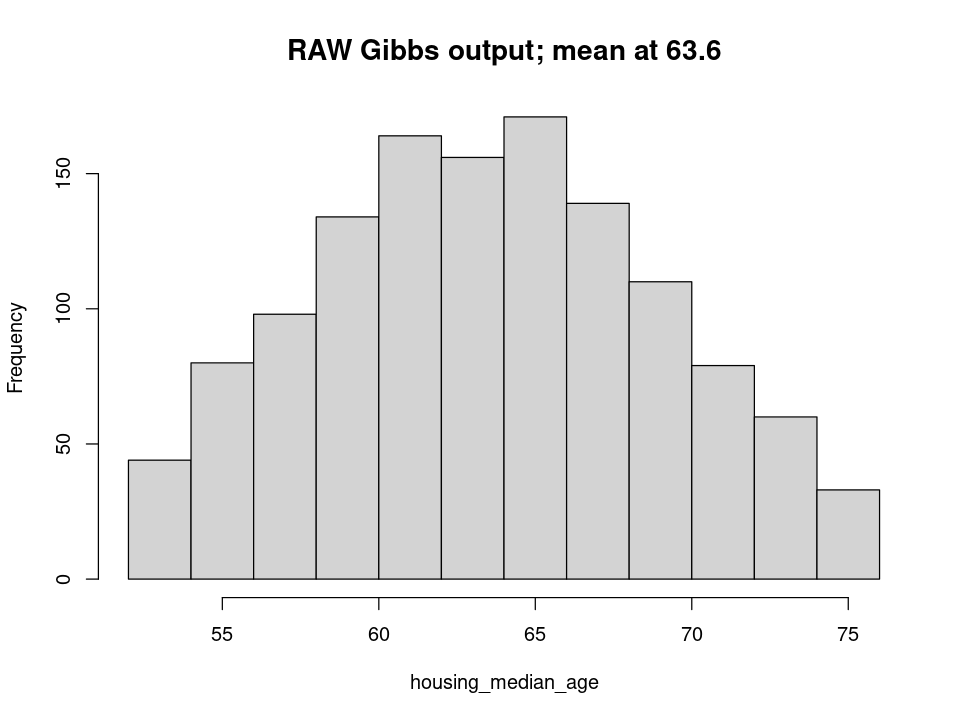

In [29]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=14, main="RAW Gibbs output; mean at 63.6",
     xlab="housing_median_age", cex.main= 1.4)


In [ ]:
### COMMENTS:

# The above shape is NOT what we expect for the imputed values.
# The mean of 63.6 is also not what we expect for the predictions.  
# This value is off by more than 10% of the expected value of 57.6.


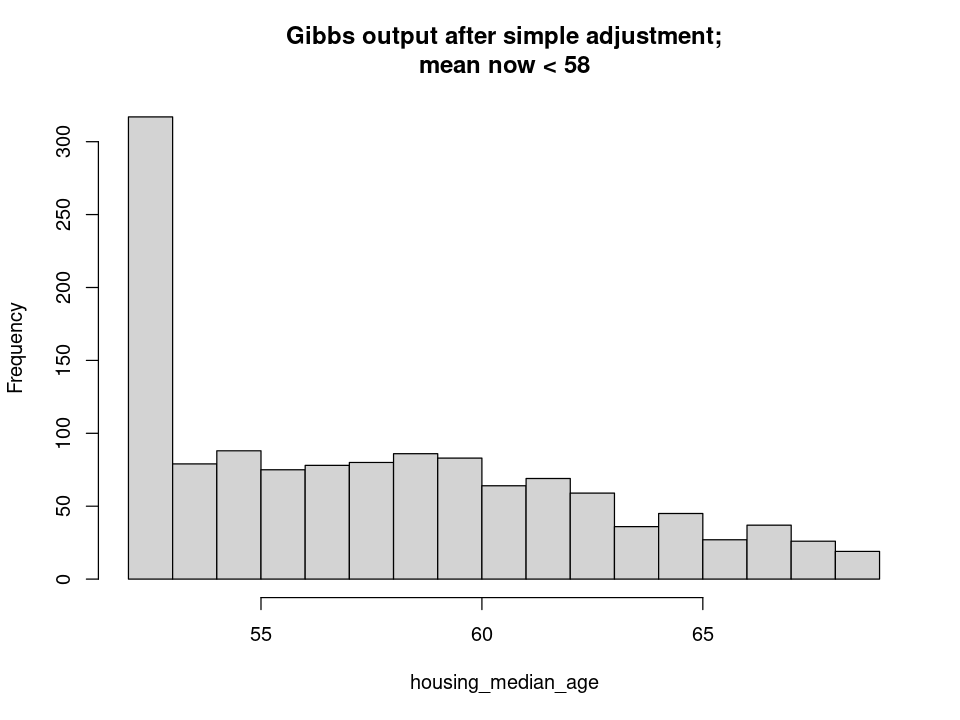

In [43]:
# Adjust the predictions based on what we learned in 
# Section 1.  We want the mean of our imputed values
# to be about 57.6.

### NOTE: the minimum standard deviation of the z_means is 
### 6.45 years.  So, although I am interfering with the 
### predictions, the interference is not extreme.

z_preds02 <- z_preds - 6.5
preds_adj <- ifelse(z_preds02 < 52, 52, z_preds02)

options(repr.plot.width= 8, repr.plot.height= 6)

hist(preds_adj, breaks=14, main="Gibbs output after simple adjustment;
mean now < 58",
     xlab="housing_median_age")


In [44]:
summary(preds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    53.1    57.0    57.6    61.1    68.5 

In [ ]:
### COMMENTS:

# While the mean and median are now where we expect them to
# be, we do not expect there to be a sudden drop in the number
# of districts as housing_median_age increases from 52 to 
# 53; we expect the drop, if there is one, to be more gradual. 

# We can fix this by adjusting z_means prior to 
# calling rnorm.trunc.


In [106]:
# The following provides us with a start.  The subtrahend
# used here will need to be adjusted once we see the truncated
# output from rnorm.trunc.

(z_means_bar <- mean(z_means))
z_means_adj <- z_means - (z_means_bar - 57.6)
mean(z_means_adj)


[1] 63.36

[1] 57.6

In [107]:
# Get new predictions.

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 2)
summary(z_preds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    55.7    59.0    59.8    63.1    75.0 

In [108]:
# Make another correction.

z_means_adj <- z_means - (z_means_bar - 53)
mean(z_means_adj)

set.seed(1933)
z_preds <- round(rnorm.trunc(n.censored, z_means_adj, z_sds, lo=C, hi=C_upper), 2)
summary(z_preds)
# The mean is now at 57.6 and the median at 56.7.


[1] 53

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    54.2    56.7    57.6    60.1    74.8 

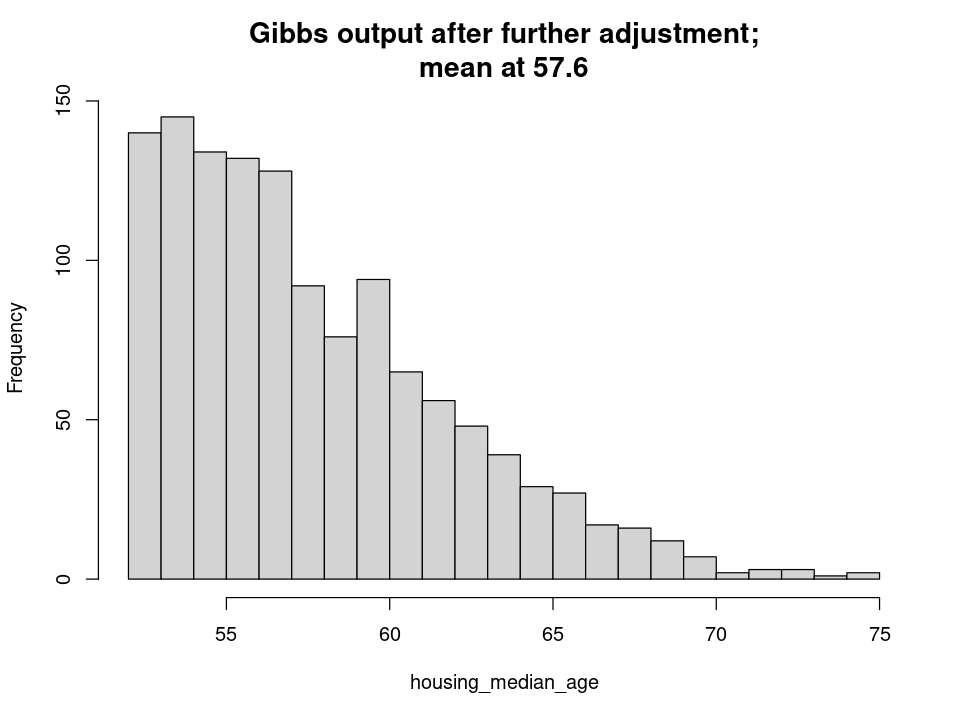

In [70]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(z_preds, breaks=20, 
     main="Gibbs output after further adjustment;
mean at 57.6", xlab="housing_median_age", cex.main=1.4)


In [ ]:
### COMMENTS:

# The shape of the above distribution is far more plausible
# than the previous distribution of adjusted predictions, 
# which had over 25% of the predictions at age 52.

# When we compare the performance of different models, I will
# treat the imputed values as if they are true, observed values.
# Thus, I want the shape of the above distribution to be like the 
# shape we would expect to see from the true values.


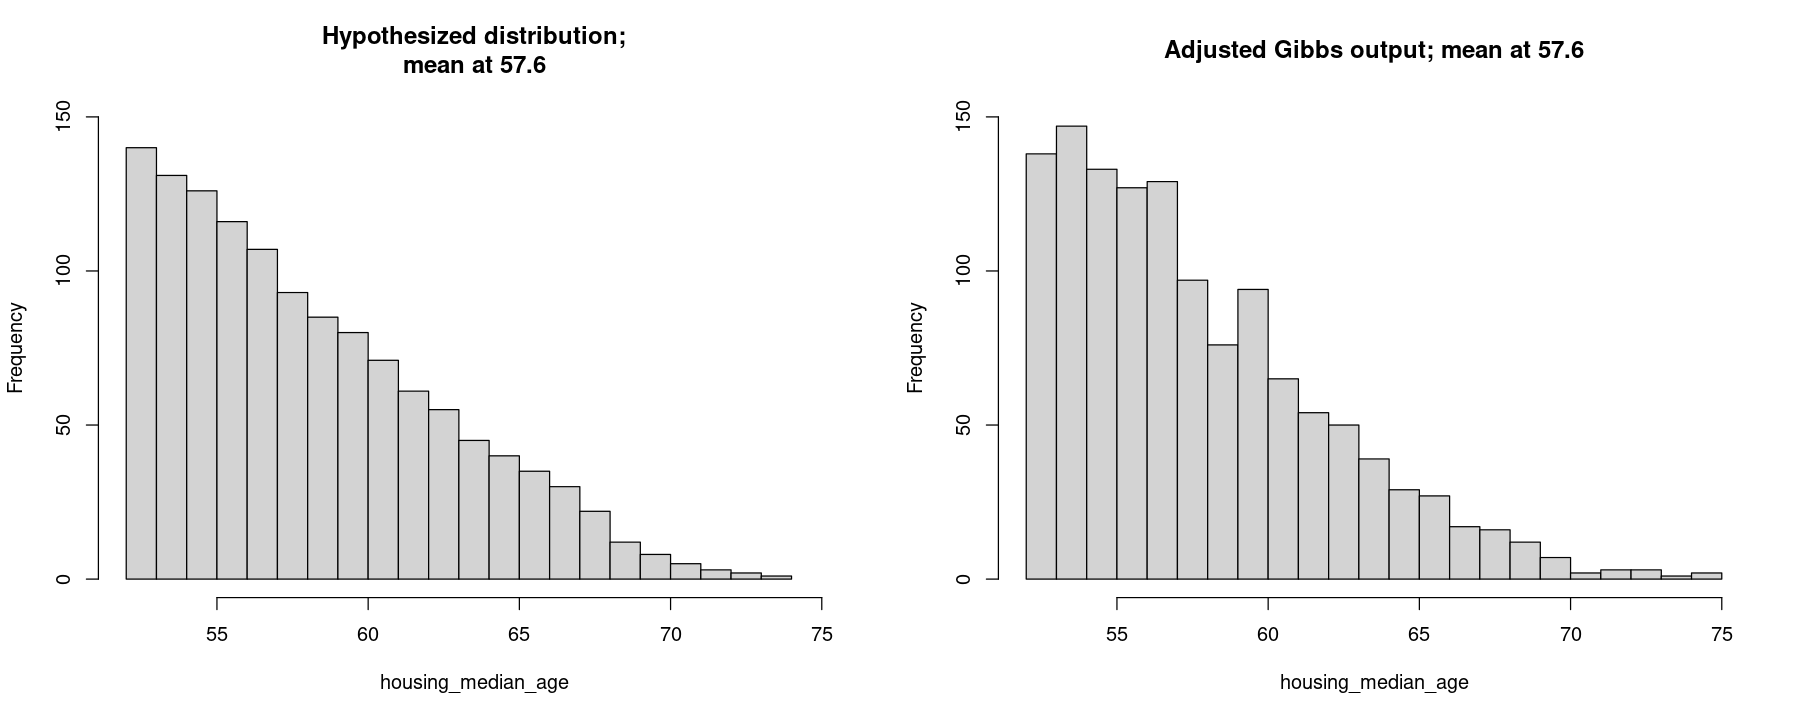

In [51]:
# Compare the hypothesized distribution with the above distribution.

options(repr.plot.width= 15, repr.plot.height= 6)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# Left panel.
hist(rep(52:73, hypdist[1:22]) + 0.02, breaks=18, main="Hypothesized distribution;
mean at 57.6", xlim=c(52, 75), ylim=c(0, 150), xlab="housing_median_age")

# Right panel.
hist(z_preds, breaks=20, main="Adjusted Gibbs output; mean at 57.6",
     ylim=c(0, 150), xlim=c(52, 75), xlab="housing_median_age")


In [ ]:
### COMMENT:

# The distribution on the right (above) does a fairly good
# job of approximating our hypothesized distribution.


In [109]:
# Assign imputed values.

newdat01 <- dat
newdat01$housing_median_age[censored] <- z_preds


In [110]:
summary(newdat01$housing_median_age)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    74.8 

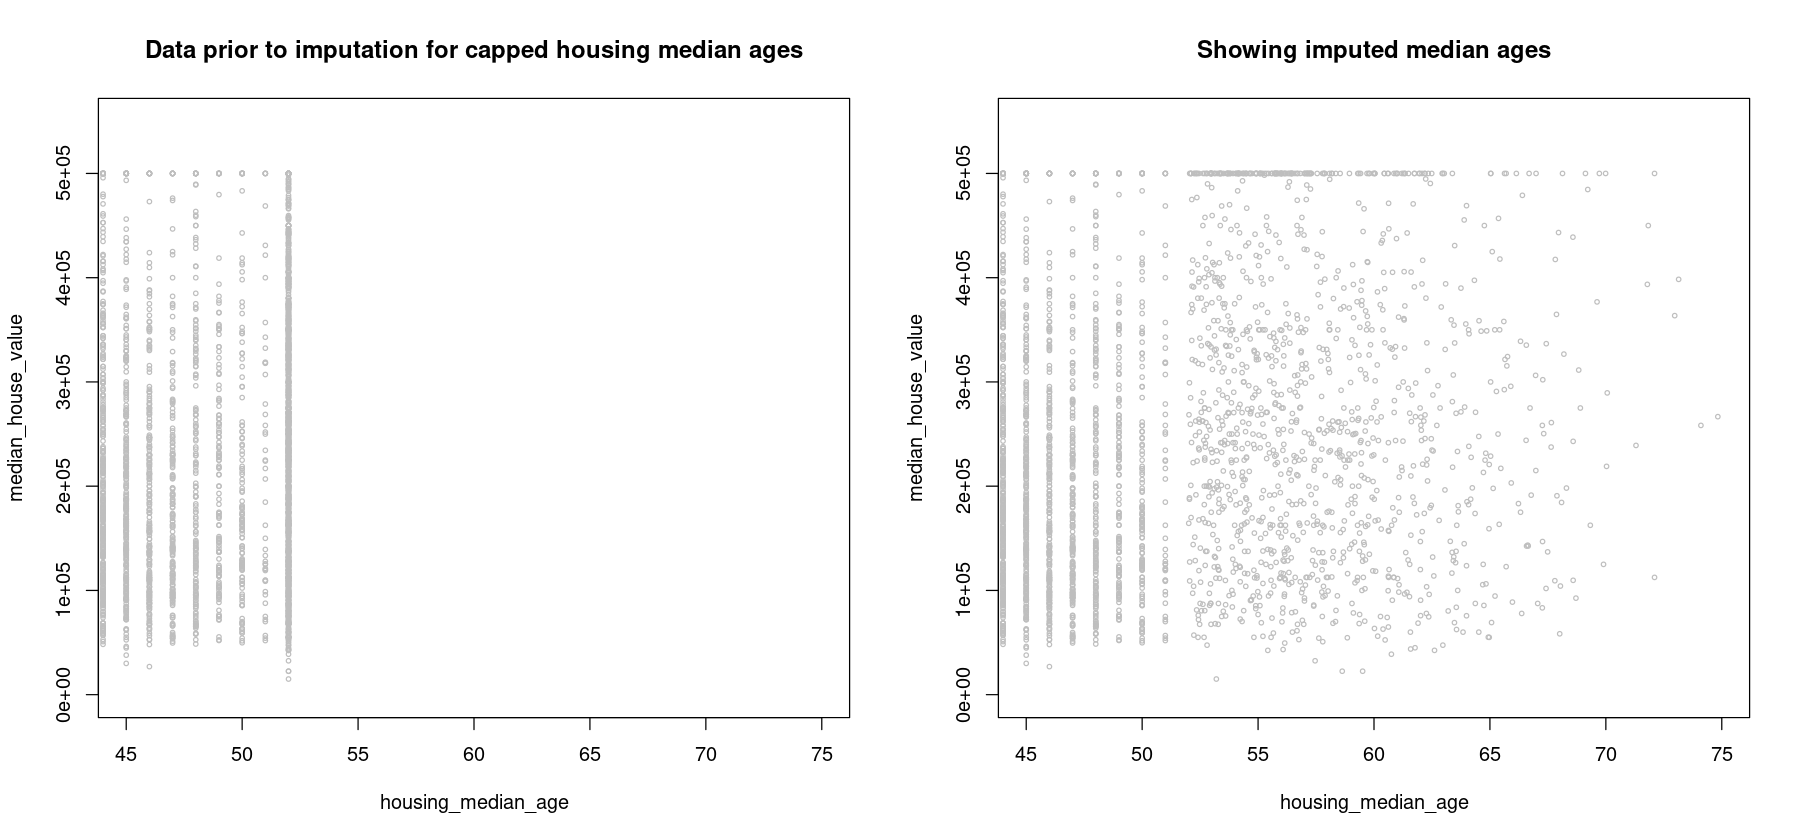

In [55]:
# Plot both before and after.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# layout.show(n = 2)

# plot the "before" scatter
plot(dat$housing_median_age, dat$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Data prior to imputation for capped housing median ages")


# plot the newly predicted values
plot(newdat01$housing_median_age, newdat01$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Showing imputed median ages")


# Section 3: A second method for imputing values

In what follows I set out another method for adjusting the Gibbs output so that it has the mean and shape of our hypothesized distribution.  Care is needed when using this method because, if the bin size is not appropriate, the RSS score of the raw Gibbs output can be adversely affected; I look into this issue in Appendix C.  Also, this alternative method can be computationally intensive.

In Appendix C I look into which of the two above approaches does better in terms of reducing the residual sum of squared differences (the differences between the imputed values and actual values).  That measurement has to be made on artificially censored housing_median_age data (I censor the data at age 32 and impute into the range 32-51).  I find that for the artificially censored data, the first approach above gives us a better RSS score.  But I assume that that is largely by accident, due to the shape which the actual, unobserved values in the range 38-51 happen to have.  For ages >= 52, there is less reason to think that the actual, unobserved values will have such a shape.

The best approach is the one that does the best job meeting all 3 criteria: (i) approximating the shape of the hypothesized distribution; (ii) approximating the mean and median of the hypothesized distribution; and (iii) having the smallest residual sum of squares.  We have already judged the raw Gibbs output in terms of (i) and (ii) and found it to be lacking.  But if it far exceeds the other two approaches per criterion (iii), then the best set of imputed values is the raw, unadjusted Gibbs output.


In [30]:
# Function which identifies the age level that a given age
# falls into.  From Appendix C I learn that a bin_size of
# 2 works better than a size of 1, at least when in imputing
# into the range 38-51.  Since the range of 52-75 is of even
# greater length, it is likely that here also a bin size of
# 2 will work better.

get_agelev <- function(val, bin_size=2) {
    
    return(floor(val/bin_size) * bin_size)
}


In [89]:
# Construct a dataframe which holds predictions for each
# of the z_means and records the probability of the z_mean
# being located at the "predicted" value.

n_preds <- 18000
cap <- C

start <- Sys.time()
dfpreds <- rep(NA, n_preds*n.censored*4)
dim(dfpreds) <- c(n_preds*n.censored, 4)
dfpreds <- as.data.frame(dfpreds)
colnames(dfpreds) <- c("rowname","predicted_val","loc_prob","agelev")

dfpreds$rowname <- rep(rows_censored, rep(n_preds, n.censored))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.8 secs


Time difference of 0.72 secs

In [90]:
# Get vectors needed for our dataframe.

probs_list <- agelev_list <- preds_list <- vector("list", length=n.censored)
names(probs_list) <- names(agelev_list) <- names(preds_list) <- rows_censored


start <- Sys.time()
for(i in 1:n.censored) {
    
    cur_mean <- z_means[i]
    cur_sd <- z_sds[i]
    cur_row <- rows_censored[i]
    
    # Get n_preds predictions for this mean.
    mu02 <- ifelse(cur_mean <= C, C , cur_mean)
    p.lo <- pnorm(C, mu02, cur_sd)
    p.hi <- pnorm(C_upper, mu02, cur_sd)
    u <- qnorm(runif(n_preds, p.lo, p.hi), mu02, cur_sd)
    loc_probs <- dnorm(u, mu02, cur_sd)
    agelev_vector <- as.vector(apply(as.matrix(u), MARGIN=2, FUN=get_agelev))
    
    probs_list[[i]] <- loc_probs
    preds_list[[i]] <- u
    agelev_list[[i]] <- agelev_vector
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.23 secs


Time difference of 1.67 secs

In [91]:
# Populate the dataframe.

start <- Sys.time()
dfpreds$predicted_val <- as.vector(unlist(preds_list))
dfpreds$loc_prob <- as.vector(unlist(probs_list))
dfpreds$agelev <- as.vector(unlist(agelev_list))

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 27.45 secs when n_preds = 30K

dim(dfpreds)
# 38,040,000    4 when n_preds = 30K

head(dfpreds); tail(dfpreds)


Time difference of 16.4 secs

[1] 22824000        4

,rowname,predicted_val,loc_prob,agelev
,<chr>,<dbl>,<dbl>,<dbl>
1,3,69.423,0.038828,68
2,3,68.638,0.043178,68
3,3,68.559,0.043607,68
4,3,68.478,0.044043,68
5,3,60.475,0.055733,60
6,3,63.627,0.060665,62


,rowname,predicted_val,loc_prob,agelev
,<chr>,<dbl>,<dbl>,<dbl>
22823995,20593,67.725,0.047694,66
22823996,20593,55.587,0.030957,54
22823997,20593,60.328,0.054303,60
22823998,20593,62.887,0.059651,62
22823999,20593,65.658,0.055959,64
22824000,20593,68.190,0.045408,68


In [92]:
rm(probs_list, agelev_list, preds_list)


In [93]:
# Order the data in dfpreds so that we can access it
# more quickly.

dfpreds <- dfpreds[order(dfpreds$agelev),]


In [36]:
# Create a new hypdist which has counts for 2-year
# intervals.  hypdist has 22 age levels.

hypdist02 <- rep(NA, 11)

index <- 1
for(i in 1:11) {
    
    hypdist02[i] <- as.numeric(hypdist[index]) + as.numeric(hypdist[index + 1])
    index <- index + 2
}
print(hypdist02)
sum(hypdist02) == 1268
sum(hypdist02)


 [1] 271 242 200 165 132 100  75  52  20   8   3


[1] TRUE

[1] 1268

In [41]:
# Compute mean of this "new" distribution.

series <- seq(from=52, to=72, by=2)

vals <- rep(series, hypdist02)
round(mean(vals), 1)
# 57.1


[1] 57.1

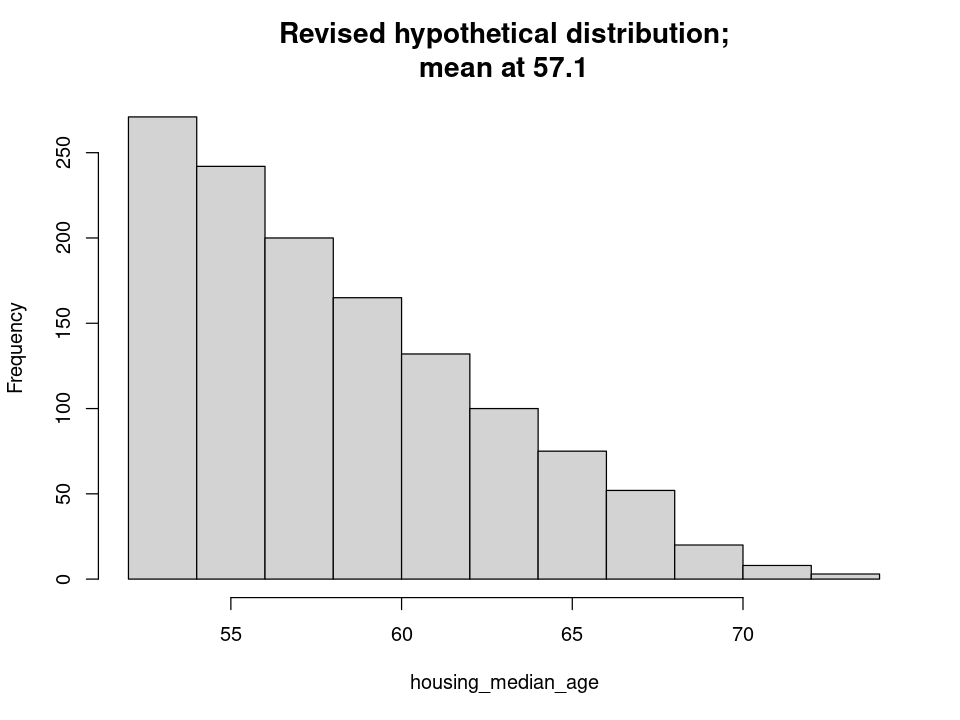

In [43]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(vals + 0.01, breaks=11, 
     main="Revised hypothetical distribution;
mean at 57.1", xlab="housing_median_age", cex.main=1.4)


In [94]:
# "APPROACH 2":

agelevs <- series
rows_to_exclude <- c()

newpreds <- c()
pred_names <- c()

# We do not want to fill the bins in sequential order from
# 1:11.
seq <- c(11:6, 1:5)

start <- Sys.time()
for(i in seq) {
    
    cur_count <- hypdist02[i]
    binval <- agelevs[i]
    
    dftmp <- dfpreds[which(dfpreds$agelev == binval),]
    
    # Remove the z_means that we have already used.
    dftmp <- dftmp[which(!(dftmp$rowname %in% rows_to_exclude)),]
    
    # For each rowname, we can only have one prediction.  The
    # probability of a rowname's predictions being in the current
    # bin should be about the same; even so, let's NOT pick out
    # the prediction with the highest probability just yet.
    dftmp <- dftmp[order(dftmp$rowname, decreasing=FALSE),]
    dftmp <- dftmp[which(!duplicated(dftmp$rowname)),]
    
    stopifnot(nrow(dftmp) >= cur_count)
    
    # If we get this far, we have enough predictions to draw from
    # to fill the current bin.  Now order the records by the
    # probabilities and then select what we need.
    dftmp <- dftmp[order(dftmp$loc_prob, decreasing=TRUE),]
    dftmp <- dftmp[1:cur_count, c("rowname","predicted_val")]
    
    newpreds <- c(newpreds, dftmp$predicted_val)
    pred_names <- c(pred_names, dftmp$rowname)
    rows_to_exclude <- c(rows_to_exclude, dftmp$rowname)
}

stop <- Sys.time()
round(stop - start, 2)
# Time difference of 59 secs


Time difference of 32.45 secs

In [95]:
length(newpreds)
length(pred_names)


[1] 1268

[1] 1268

In [96]:
length(unique(pred_names))


[1] 1268

In [97]:
names(newpreds) <- pred_names
summary(newpreds)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   53.3    55.6    57.7    58.5    61.2    72.0 

In [98]:
# Since the mean has increased quite a bit, we 
# should make an adjustment.

newpreds_adj <- newpreds - 1
summary(newpreds_adj)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.3    54.6    56.7    57.5    60.2    71.0 

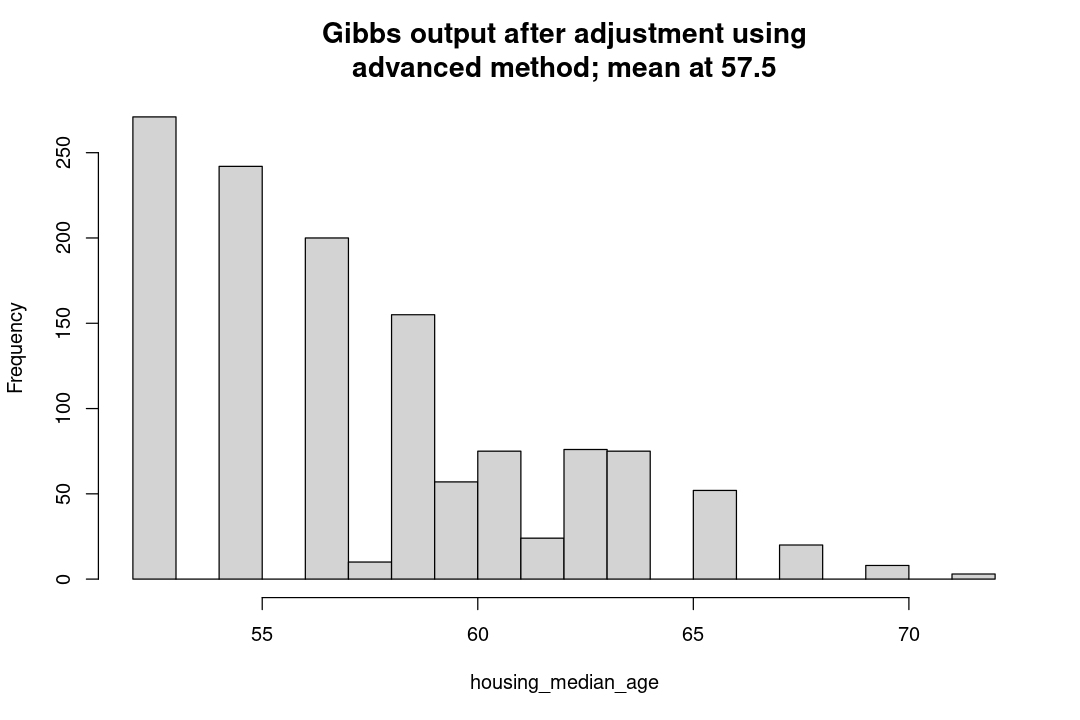

In [99]:
# Check shape of the distribution.

options(repr.plot.width= 9, repr.plot.height= 6)

hist(newpreds_adj, breaks=20, main="Gibbs output after adjustment using
advanced method; mean at 57.5", xlab="housing_median_age", cex.main=1.4)


In [100]:
# We can fix the distribution by jittering the values.  
# Recall that the minimum z_sds is 6.45 years.  So if
# we jitter by a 1-year amount, we should not ruin the
# RSS gain.

set.seed(1232)
tmpdat <- jitter(newpreds_adj, amount=0.9)
newpreds_adj02 <- ifelse(tmpdat < 52, 52, tmpdat)
summary(newpreds_adj02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   52.0    54.2    56.8    57.5    60.3    71.8 

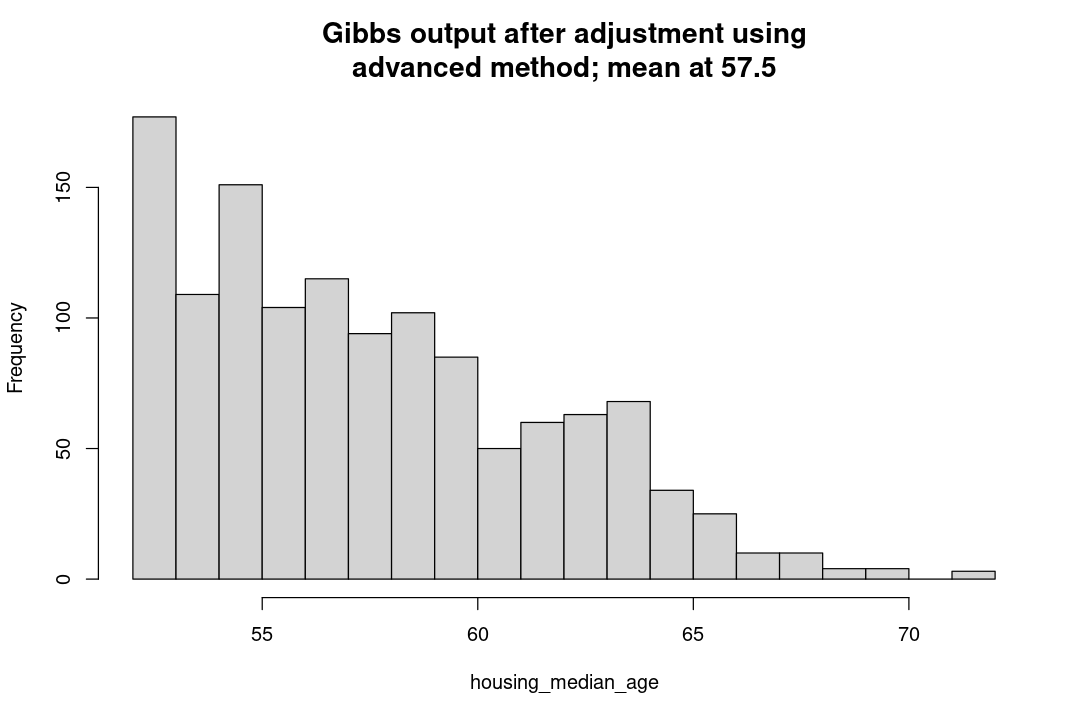

In [101]:
options(repr.plot.width= 9, repr.plot.height= 6)

hist(newpreds_adj02, breaks=20, main="Gibbs output after adjustment using
advanced method; mean at 57.5", xlab="housing_median_age", cex.main=1.4)


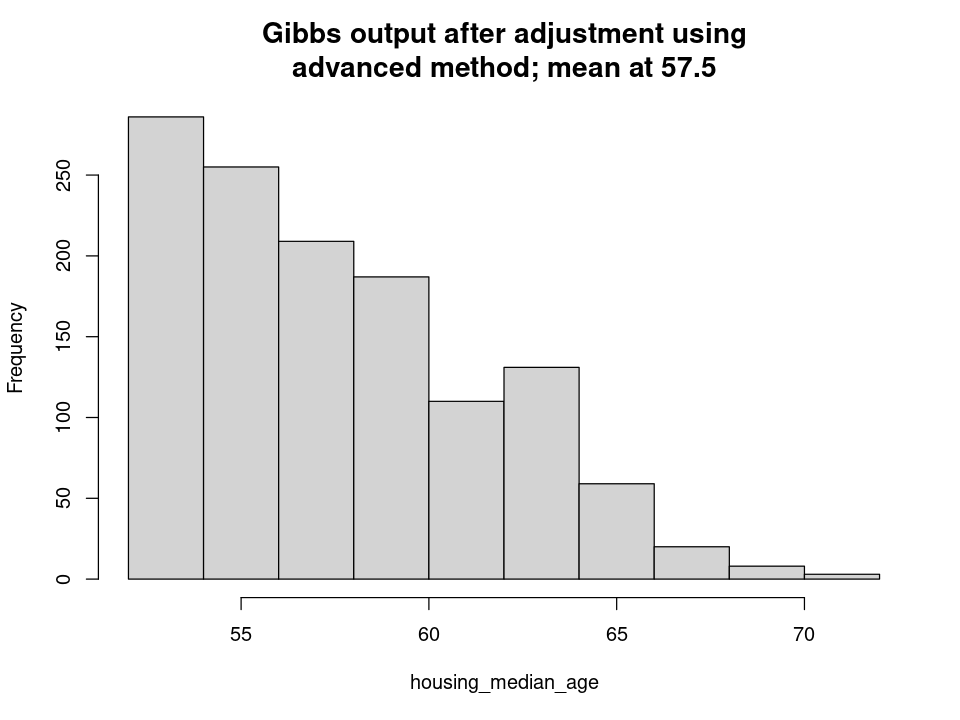

In [102]:
options(repr.plot.width= 8, repr.plot.height= 6)

hist(newpreds_adj02, breaks=11, main="Gibbs output after adjustment using
advanced method; mean at 57.5", xlab="housing_median_age", cex.main=1.4)

# The following shape is fairly close to what we expect to see.


In [104]:
dim(dat[rows_censored,])
length(newpreds_adj02[rows_censored])


[1] 1268   15

[1] 1268

In [105]:
# Assign imputed values to the correct records in dat.

newdat02 <- dat
newdat02[rows_censored, c("housing_median_age")] <- as.numeric(newpreds_adj02[rows_censored])
summary(newdat02$housing_median_age)

# The following summary is the same as that for newdat01.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    18.0    29.0    29.0    37.0    71.8 

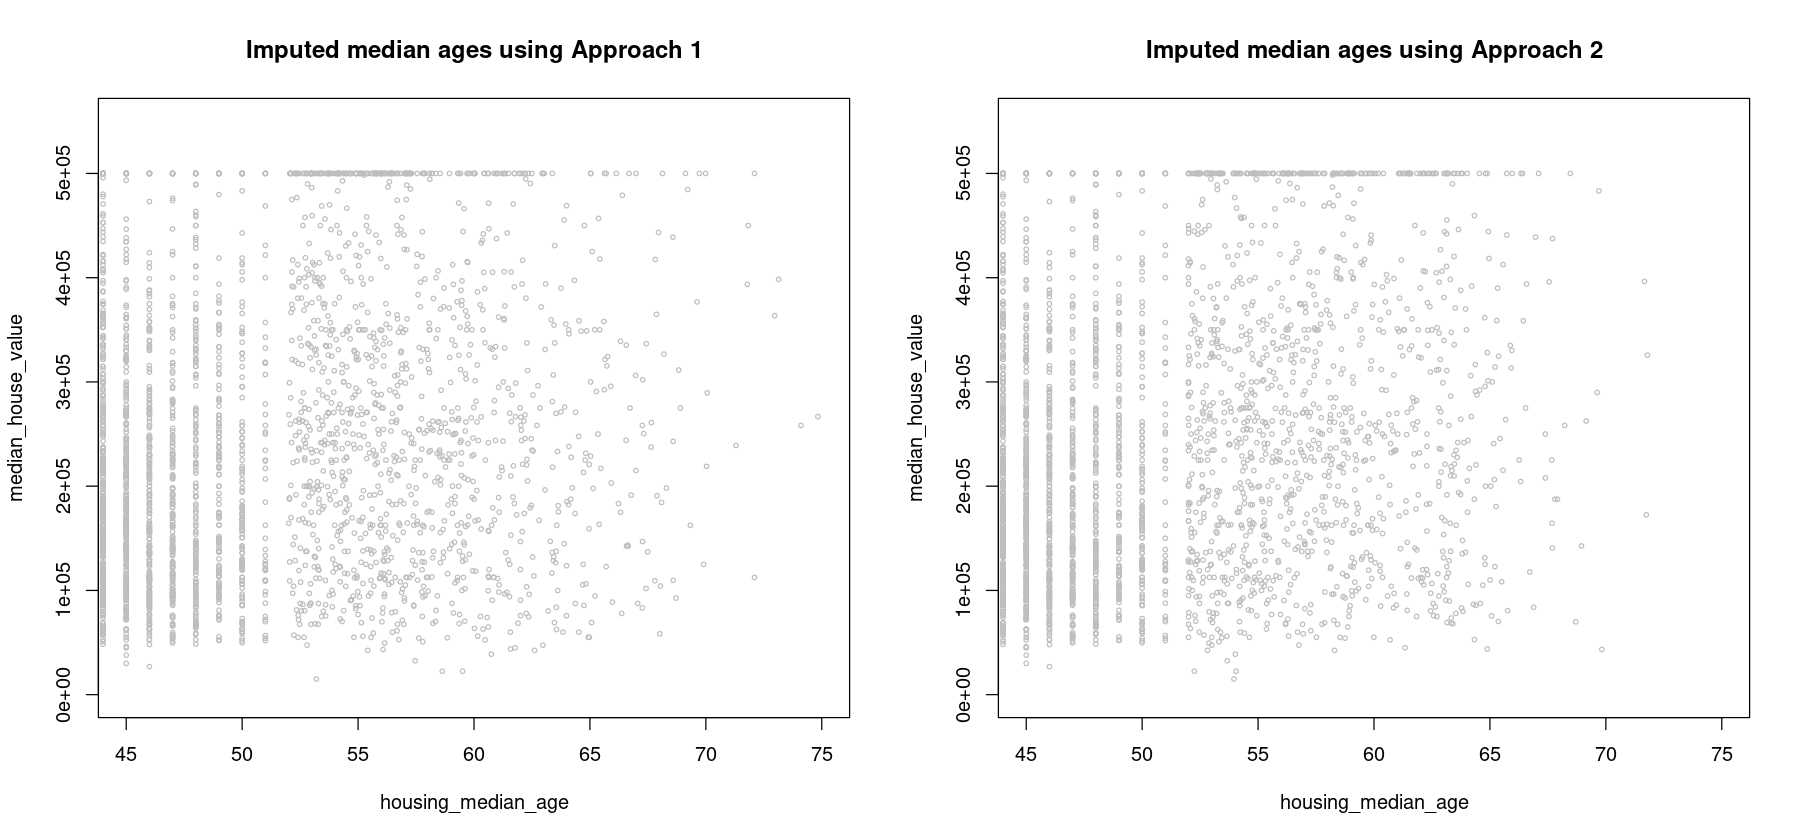

In [111]:
# Compare the scatterplots of Approach 1 vs Approach 2.

options(repr.plot.width= 15, repr.plot.height= 7)

mat <- t(as.matrix(c(1,2)))
layout(mat, widths = rep.int(20, ncol(mat)),
       heights = rep.int(7, nrow(mat)), respect = FALSE)

# plot Approach 1 scatter
plot(newdat01$housing_median_age, newdat01$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Imputed median ages using Approach 1")


# plot Approach 2 scatter
plot(newdat02$housing_median_age, newdat02$median_house_value, type= "p", pch=1, cex=0.5, col="grey",
     xlab= "housing_median_age", ylab= "median_house_value", ylim= c(0, 0.55e06), xlim= c(45, 75),
     main= "Imputed median ages using Approach 2")


In [ ]:
### COMMENTS:

# For this data, I think Approach 1 works better than Approach 2.  Look 
# back at how closely the Approach 1 distribution approximates the 
# expected distribution.  As far as I can tell, Approach 1 does as good
# a job as Approach 2 in terms of meeting the shape requirement.
# A problem for the distribution of Approach 2 is the bin size of 2.
# Again, this size is chosen based on what we see in Appendix C.  It is
# supposed to give us a much better RSS gain with this data.  But we
# also see in Appendix C that Approach 1, for this data anyway, has
# the best RSS gain.


### Save to disk

In [112]:
# Saving imputed values for housing_median_age to housing_cleaned_v03.csv.

write.csv(newdat01,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03a.csv",
          row.names=TRUE)

write.csv(newdat02,
          file="/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03b.csv",
          row.names=TRUE)


In [232]:
rm(newdat01, newdat02)


In [113]:
# We want to use _v03a.csv in Appendix B and in Part01 and Part02.

dat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/housing_cleaned_v03a.csv",
                header=TRUE, row.names=1,
                colClasses= c("character", rep("numeric", 9), "character",
                              rep("numeric", 5)))
dim(dat); colnames(dat)


[1] 20603    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"

## Final Comments for Appendix A

The basic problem facing us with the capped data is that we need to impute values into a region for which we have no data.  And if the model we build for predicting housing_median_age has no data to work with in the region where the imputed values should lie, this model will nearly always generate predictions within the range of the data from which it was built.  The Gibbs sampler provides us with a solution to this problem.  But it is not a solution we should always accept without adjustments, for it can only yield a distribution for the imputed values that is the same as that built into our model assumptions for the response variable.

With the censored housing median age values, we are imputing values at the tail of the distribution.  Thus, we do not expect the imputed values to have a normal distribution.  Because we are at the tail end of the variable's range, we know that the counts at the different age levels in the range of imputation are likely to decrease very nearly monotonically.  In other words, we have a good idea of what the general shape of the actual, unobserved values is likely to be.  We can make this belief concrete as I have done above with the hypothesized distribution.  We can get an even better handle on the true, unobserved distribution if we can accurately predict the mean and/or median.  An accurate prediction not only tells us something about how fast the counts are dropping, but also something about how good the unadjusted output from the Gibbs sampler is.

In this appendix I have offered a *general* method for getting a good prediction of the mean of the true, unobserved values of the censored records and for re-creating the shape of our hypothesized distribution.  We see another application of the method in Appendix B.  By adjusting the raw Gibbs output (when necessary), we end up with a much more plausible set of imputed values.  In fact, the imputed values are plausible enough that for certain purposes we can treat them as if they were observed data.  This is exactly what I do with the imputed values for the 4.8\% of the records with a censored median house value when I compute comparative root mean square error (rmse) scores.  The average error for our predictions for median house value then becomes an average over **all** Census districts in California and not just those with an expected median house value less than 500K.


